# Import Libries

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from factor_analyzer import FactorAnalyzer,calculate_kmo
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import seaborn as sns
from math import sqrt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Preprocessing

In [3]:
train = pd.read_csv("./train.csv")
train = train.drop(['id'], axis=1)
train.head()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1,55,1885,136.83,152.29,0,0,177
1,1,55,1993,136.83,135.83,0,0,270
2,1,55,2539,134.86,135.86,0,0,189
3,1,55,2139,339.50,437.53,0,0,54
4,1,55,2631,243.50,242.50,0,0,40


In [4]:
#check the missing value and the information of dataset
print(train.isnull().sum())
print('\n')
print(train.info())

week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   week                   456548 non-null  int64  
 1   center_id              456548 non-null  int64  
 2   meal_id                456548 non-null  int64  
 3   checkout_price         456548 non-null  float64
 4   base_price             456548 non-null  float64
 5   emailer_for_promotion  456548 non-null  int64  
 6   homepage_featured      456548 non-null  int64  
 7   num_orders             456548 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 27.9 MB
None


## Exploratory Data Analysis

In [5]:
train.describe()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
count,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000
mean,74.768771,82.105796,2024.337458,332.238933,354.156627,0.081152,0.10920,261.872760
std,41.524956,45.975046,547.420920,152.939723,160.715914,0.273069,0.31189,395.922798
min,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.00000,13.000000
25%,39.000000,43.000000,1558.000000,228.950000,243.500000,0.000000,0.00000,54.000000
50%,76.000000,76.000000,1993.000000,296.820000,310.460000,0.000000,0.00000,136.000000
75%,111.000000,110.000000,2539.000000,445.230000,458.870000,0.000000,0.00000,324.000000
max,145.000000,186.000000,2956.000000,866.270000,866.270000,1.000000,1.00000,24299.000000


Data Overview

    · The dataset contains a total of 456548 records and includes 8 variables related to orders

Week

    · The average of week is weeks 74.8
    · The standard deviation is 41.52 means that it has relatively high variability (coefficient of variation = 55.5%)
    · The range of week is from 1 to 145
    · 25% of weeks are below 39, 50% of weeks are below 76, 75% of weeks are below 111

Chekcout Price

    · The average checkout price is 332.24 and it seems that most orders are placed within in this range
    · The standard deviation of 152.94 means that it has relatively high variability (coefficient of variation = 46%), and some orders are much higher or lower than the average
    · The range of checkout price is from 2.97 to 866.27
    · 25% of checkout prices are below 228.95, 50% of checkout prices are below 296.82, 75% of checkout prices are below 445.23

Base Price

    · The average of base price is 354.16 (It slightly higher than the checkout price on average, which could be due to discounts or other charges)
    · The standard deviation of 160.72 means that it has relatively high variability (coefficient of variation = 45.38%), and some orders base price are much higher or lower than the average
    · The range of base price is from 55.36 to 866.27
    · 25% of base prices are below 243.50, 50% of base prices are below 310.46, 75% of base prices are below 458.87

Emailer for Promotion

    . 0 represents the meal was not included in an email promotion while 1 represents the meal was included in an email promotion
    · The average value is 0.081 which indicates that only about 8.1% of the meals were promoted via email campaigns, and the distribution is heavily skewed towards 0 (most meals were not promoted via email)
    · It has relatively high variability
    . 25%, 50%, and 75% values are all 0, showing that the majority of meals were not included in email promotions

Homepage Featured

    . 0 represents the meal was not featured on the homepage while 1 represents the meal was featured on the home page
    · The average of homepage featured is 0.109 which suggests that only about 10.9% of the meals in the dataset were featured on the homepage and the distribution is heavily skewed towards 0 (meals not being featured)
    · It has a relatively high variability
    . 25%, 50%, and 75% are all 0, showing that the majority of meals were not featured on the homepage

Number of Orders

    · The average of number of orders is 261.87
    · With a standard deviation of 395.92, there is considerable variance in the number of orders and some of the records are much higher than the average
    · The range of orders is from 13 to 24299
    · 25% of the number of orders are below 54, 50% of the number of orders are below 136, 75% of the number of orders are price below 324

For other categorical variables like center_id and meal_id
        · The mean and standard deviation are not the most informative measures (because of too many categories)
        · We will focus on frenquency and mode for explaining

In [6]:
train.mode()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,122,13,2290,290.03,292.03,0,0,13


The value 13 is the most frequent for the center_id column. This suggests that a significant portion of the orders originate from the service center with ID 13.

The value 2290 is the most frequent for the meal_id column. This indicates that a specific meal is the most commonly ordered across all centers, reflecting its popularity or consistent demand.

In [7]:
train.skew()

week                    -0.049517
center_id                0.345130
meal_id                 -0.172884
checkout_price           0.672330
base_price               0.637661
emailer_for_promotion    3.067713
homepage_featured        2.506022
num_orders               6.929966
dtype: float64

Some of the variables have positive skewness and a long tail on the right side, which means that most of them are small, but sometimes, a few larger values pull up the distribution on the right side.

Vice versa for the negative skewness

However, most of the variables are close to the symmetric skewness (zero value)

In [8]:
train.kurtosis()

week                      -1.179503
center_id                 -0.805220
meal_id                   -1.243111
checkout_price            -0.252819
base_price                -0.506162
emailer_for_promotion      7.410897
homepage_featured          4.280163
num_orders               121.852220
dtype: float64

In kurtosis, except emailer for promotion, homepage featured, and number of orders has more extreme value and these distribution have heavy tails (kurtosis > 3)

While the distribution for others is flatter (platykurtic distribution) and extreme bias occur less frequently (kurtosis < 3)

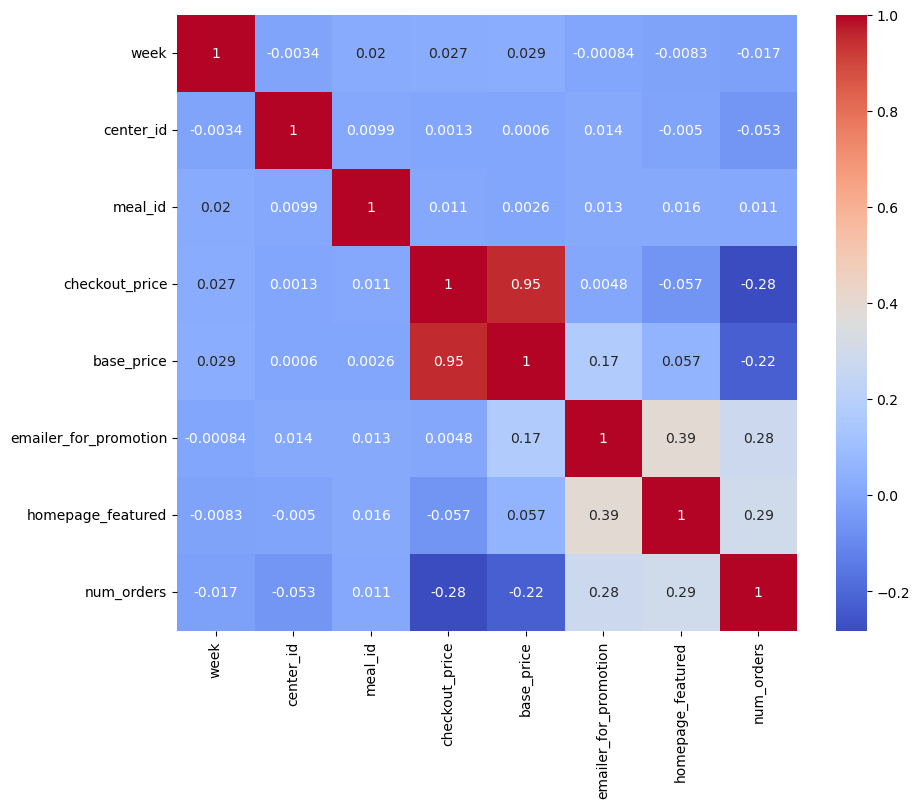

In [9]:
plt.figure(figsize=(10,8))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.show()

Strong Correlation

    . The checkout_price and base_price have strong positive correlation (correlation=0.95) which show that the checkout price is often determined by the base price
    
Moderate Correlation

    . The homepage_feature and email_for_promotion have moderate positive correlation (correlation=0.39) to each, suggests that meals featured on the homepage may also be part of email promotions, but they are not always used together

Weak or no correlation

    . For checkout_price and num_orders (correlation=-0.28) and base_price and num_orders (correlation=-0.22) have a weak negative correlation, means that when one of them become higher, another might be fewer.
    ' For other variables, they show very weak correlation with most other variables which sugguest that they do not directly influence themselves

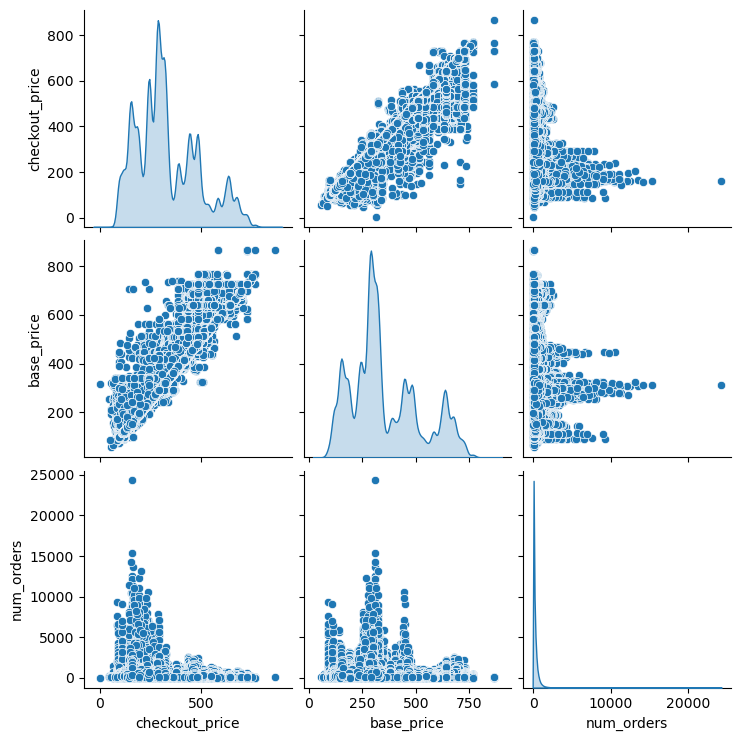

In [10]:
sns.pairplot(train[['checkout_price', 'base_price', 'num_orders']], diag_kind='kde')
plt.show()

The diagonal elements are kernal density estimation plots showing the distribution of individual variables

    · num_orders variable have a skewed distribution while checkout price and base price are more densely distributed in certain ranges

The off diagonal elements are showing pairwise relationships between variables

    · For the base price and checkout price, the scatter plot shows a strong positive correlation because the higher the base price, the higher the checkout price. (Has strong positive correlation)
    · However, the number of orders with checkout_price and base_price does not have obvious linear correlation or strong relationship.

In [11]:
def histogram_plot(x, title):
    plt.hist(x)
    plt.title(title)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

def plot_bar(x, column):

    value_counts = x[column].value_counts()
    max_value = value_counts.idxmax()
    max_count = value_counts.max()

    # Plot the bar chart
    plt.figure(figsize=(20, 10))
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.xticks(rotation=90)
    plt.title(column)
    plt.show()

    # Print the most frequent value and its count
    print(f"Most frequent value for {column}: {max_value} (Frequency: {max_count})")

def plot_boxplots(x, columns, orient='v'):

    data_melted = x[columns].melt(var_name='Variable', value_name='Value')

    plt.figure(figsize=(15, 10))
    sns.boxplot(x='Variable', y='Value', data=data_melted, orient=orient)
    plt.title('Combined Boxplot of Selected Columns')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

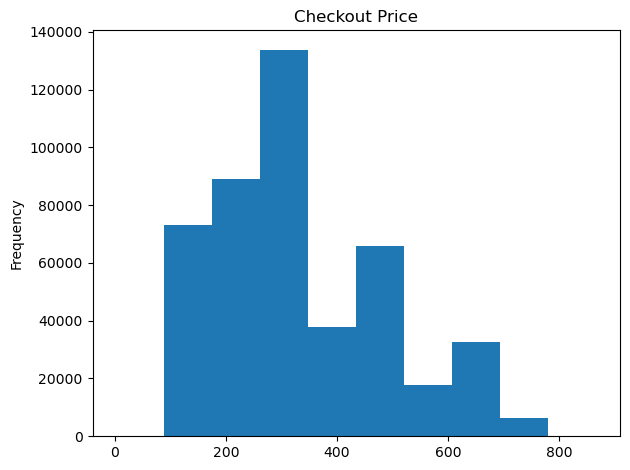

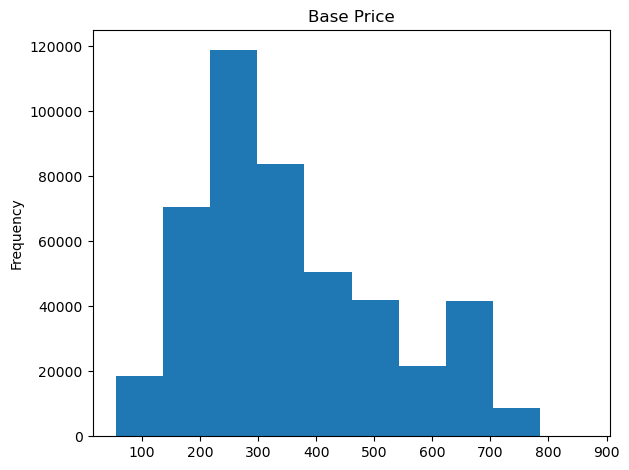

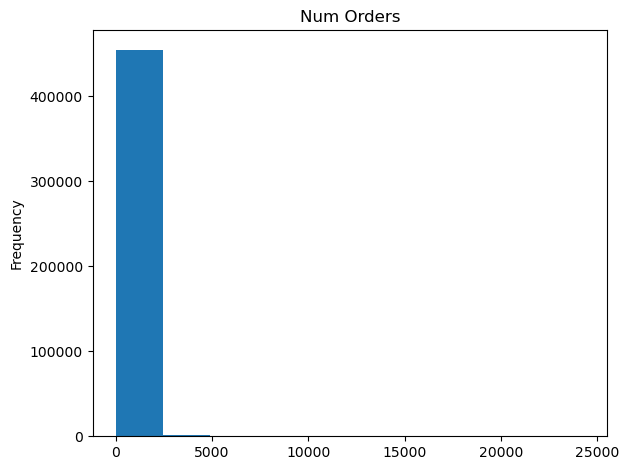

In [12]:
# use the histogram to plot the numerical variables
columns_to_plot = ['checkout_price', 'base_price', 'num_orders']
for col in columns_to_plot:
    histogram_plot(train[col], title=f"{col.replace('_', ' ').title()}")

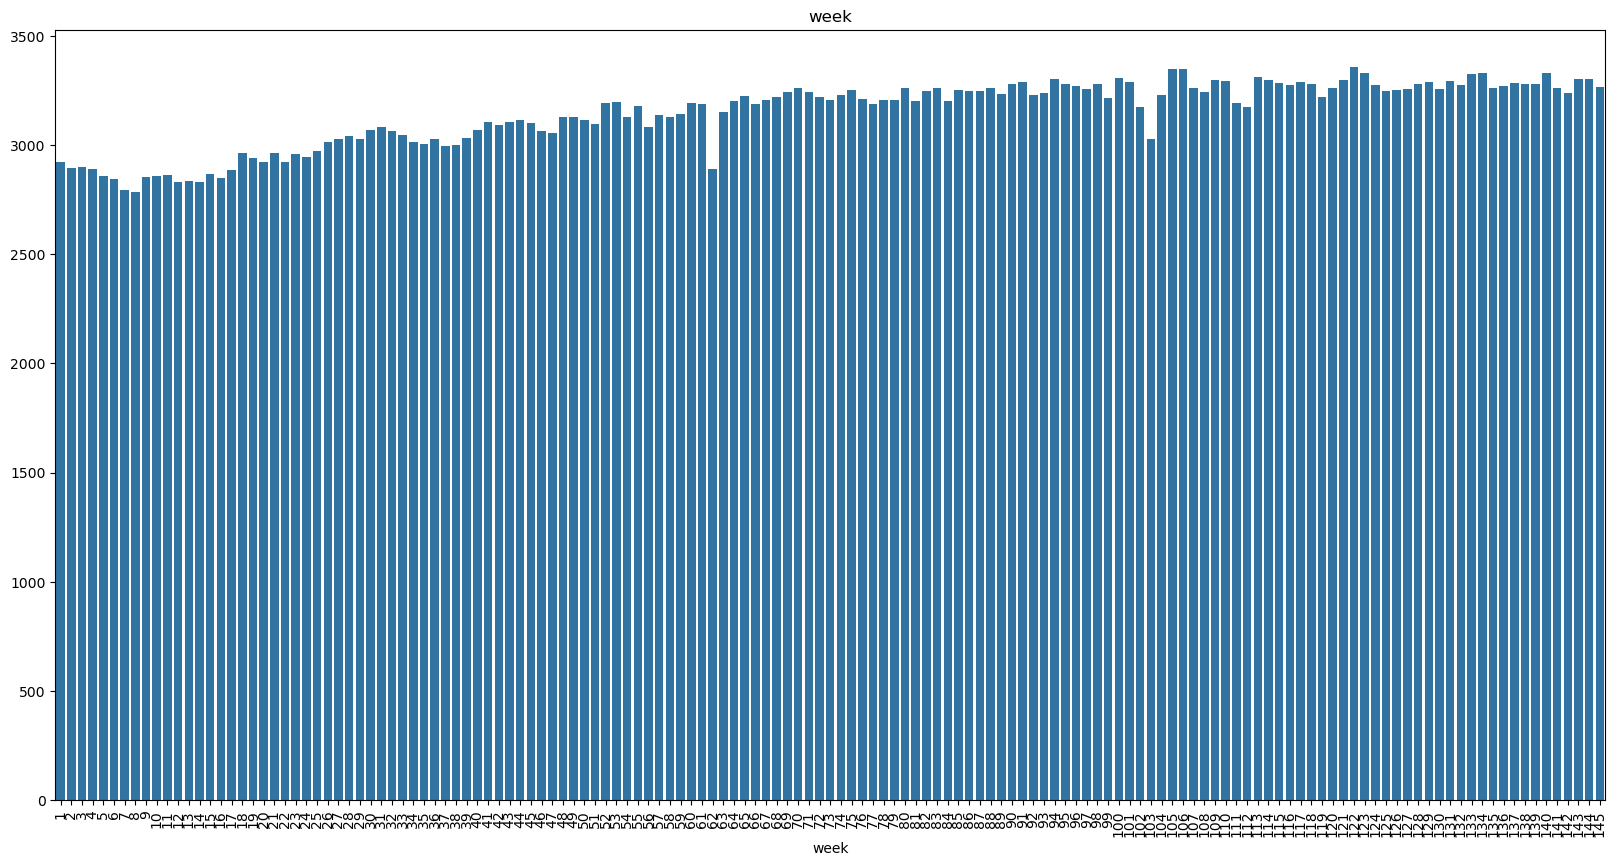

Most frequent value for week: 122 (Frequency: 3359)


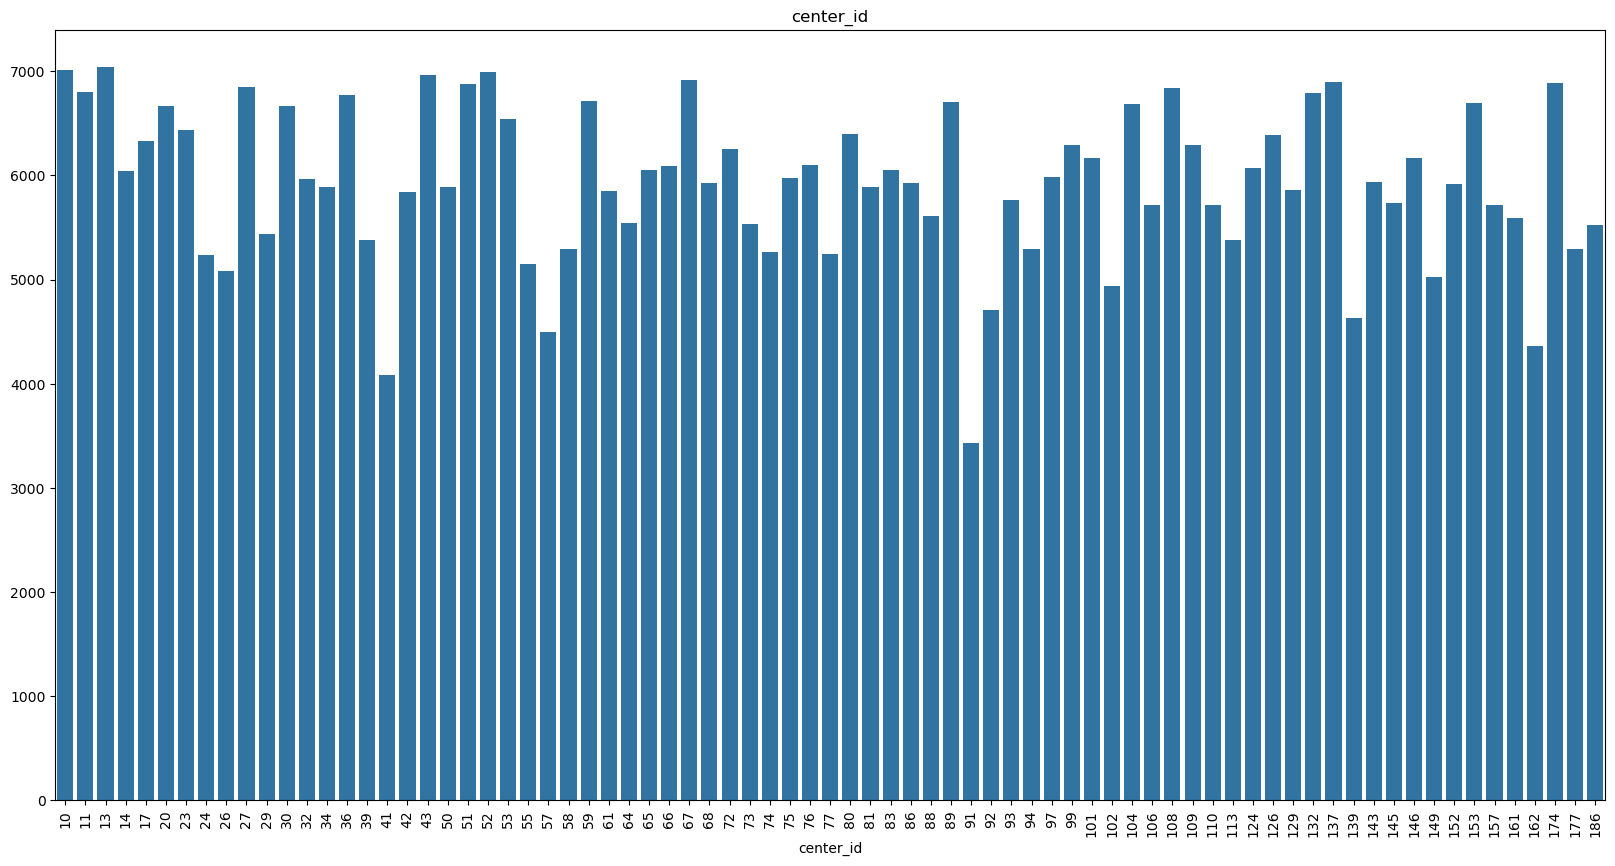

Most frequent value for center_id: 13 (Frequency: 7046)


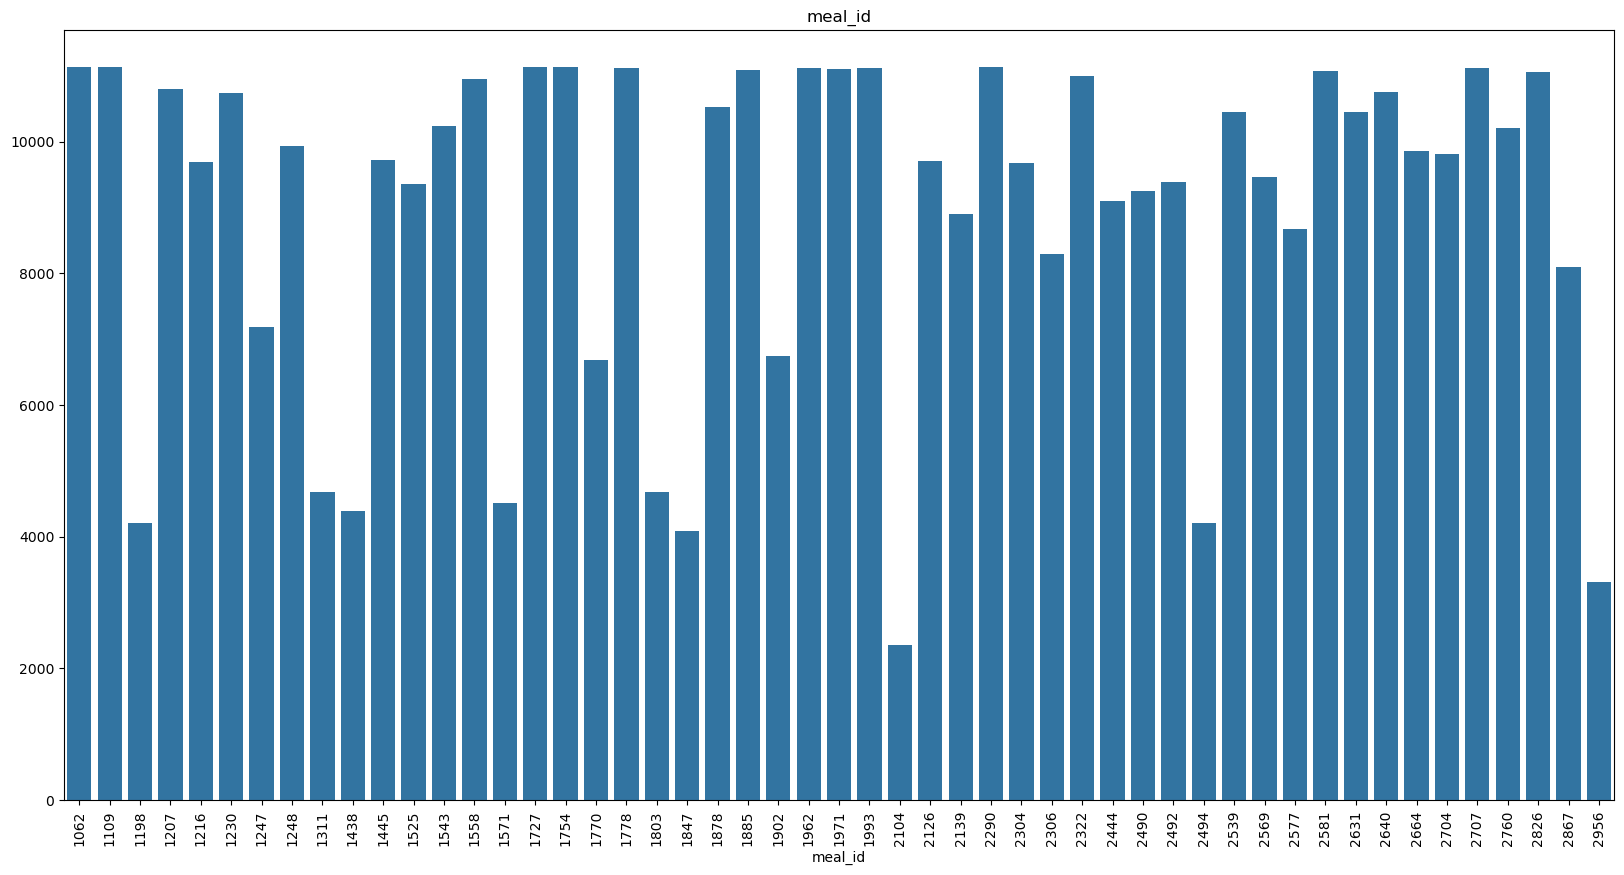

Most frequent value for meal_id: 2290 (Frequency: 11138)


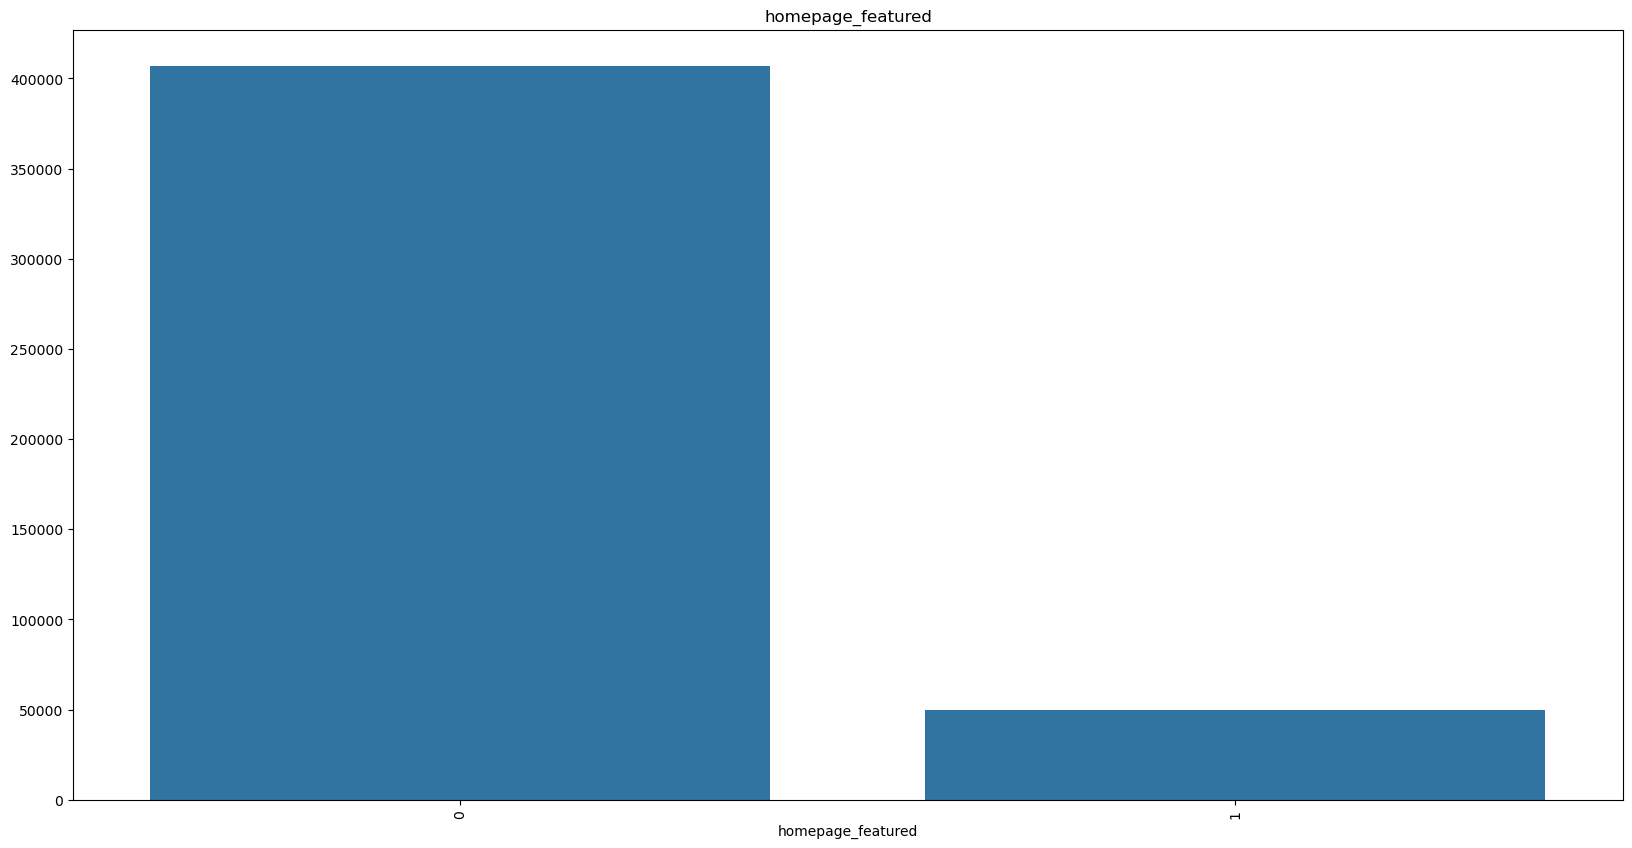

Most frequent value for homepage_featured: 0 (Frequency: 406693)


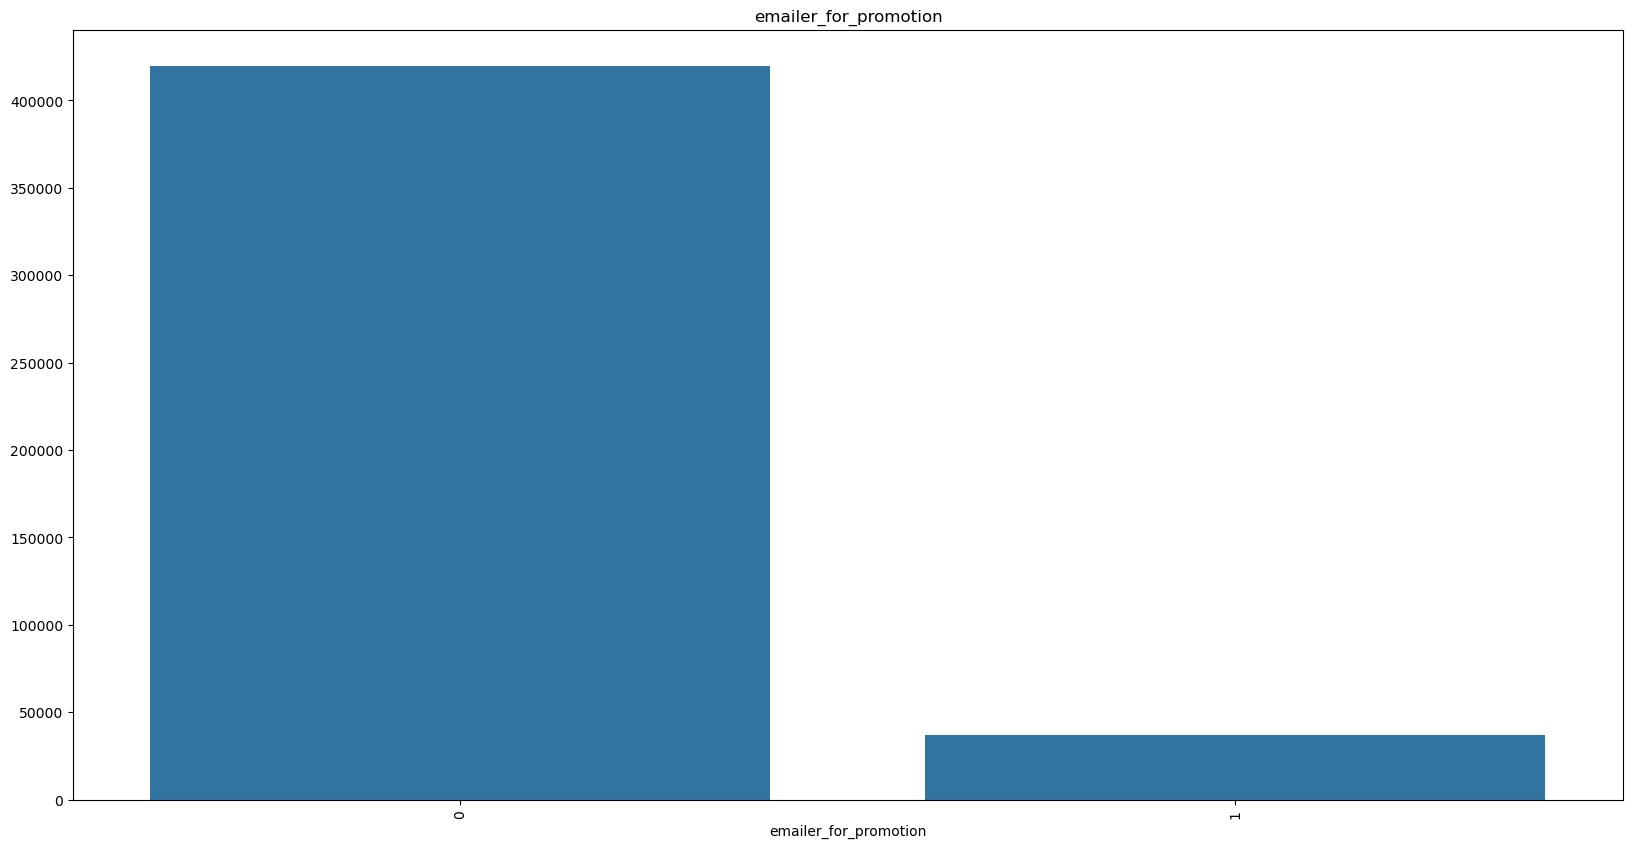

Most frequent value for emailer_for_promotion: 0 (Frequency: 419498)


In [13]:
# use the bar plot to plot the categorical variables
columns_to_plot = train[['week', 'center_id', 'meal_id', 'homepage_featured', 'emailer_for_promotion']]

for column in columns_to_plot.columns:
    plot_bar(columns_to_plot, column)

Week

    · Week '122' has the highest frequency.
    · The difference between the weeks is even.

Center ID

    · Center ID '13' has the highest frequency.
    · The difference between the center id types is substantial. For example '13' and '91' has the highest gap

Meal ID

    · Meal ID '2290' has the highest frequency. It is probably the most popular dish and also in high demand among consumers
    · The top meals in this list have orders in a tight range, suggesting that while preferences may differ, the demand for these meals remains relatively high and stable

 Homepage Featured

     · 0 has the highest frequency shows that the majority of meals were not featured on the homepage

 Emailer for Promotion

     · 0 has the highest frequency shows that the majority of meals were not included in email promotions

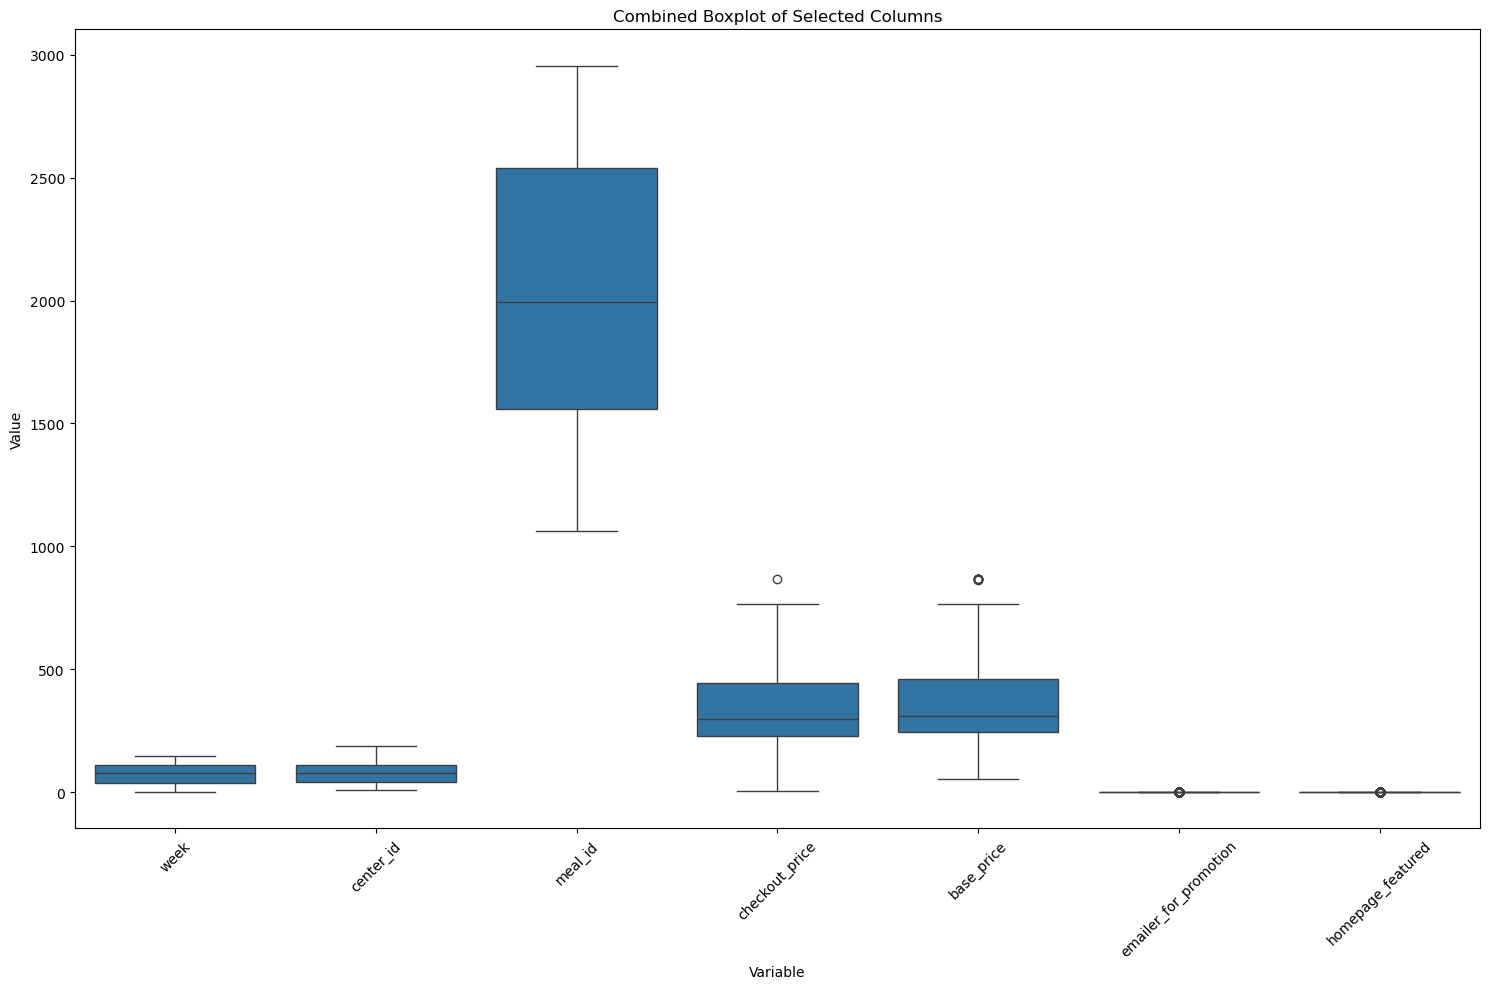

In [14]:
plot_boxplots(train, ['week', 'center_id', 'meal_id', 'checkout_price', 'base_price', 'emailer_for_promotion', 'homepage_featured'])

The box in the boxplot represent the IQR which contain the middle 50% of the data

The whiskers extend to the largest and smallest values

The individual points beyond the whiskers represent the outliers

Analysis

    · There are significant differences in the range of values of the variables as evident by the height of the boxes
    · In checkout price and base price have been obeserved some outliers and show that it could have the extreme cases
    · Variables with a median closer to one edge of box indicate that the data are skewed

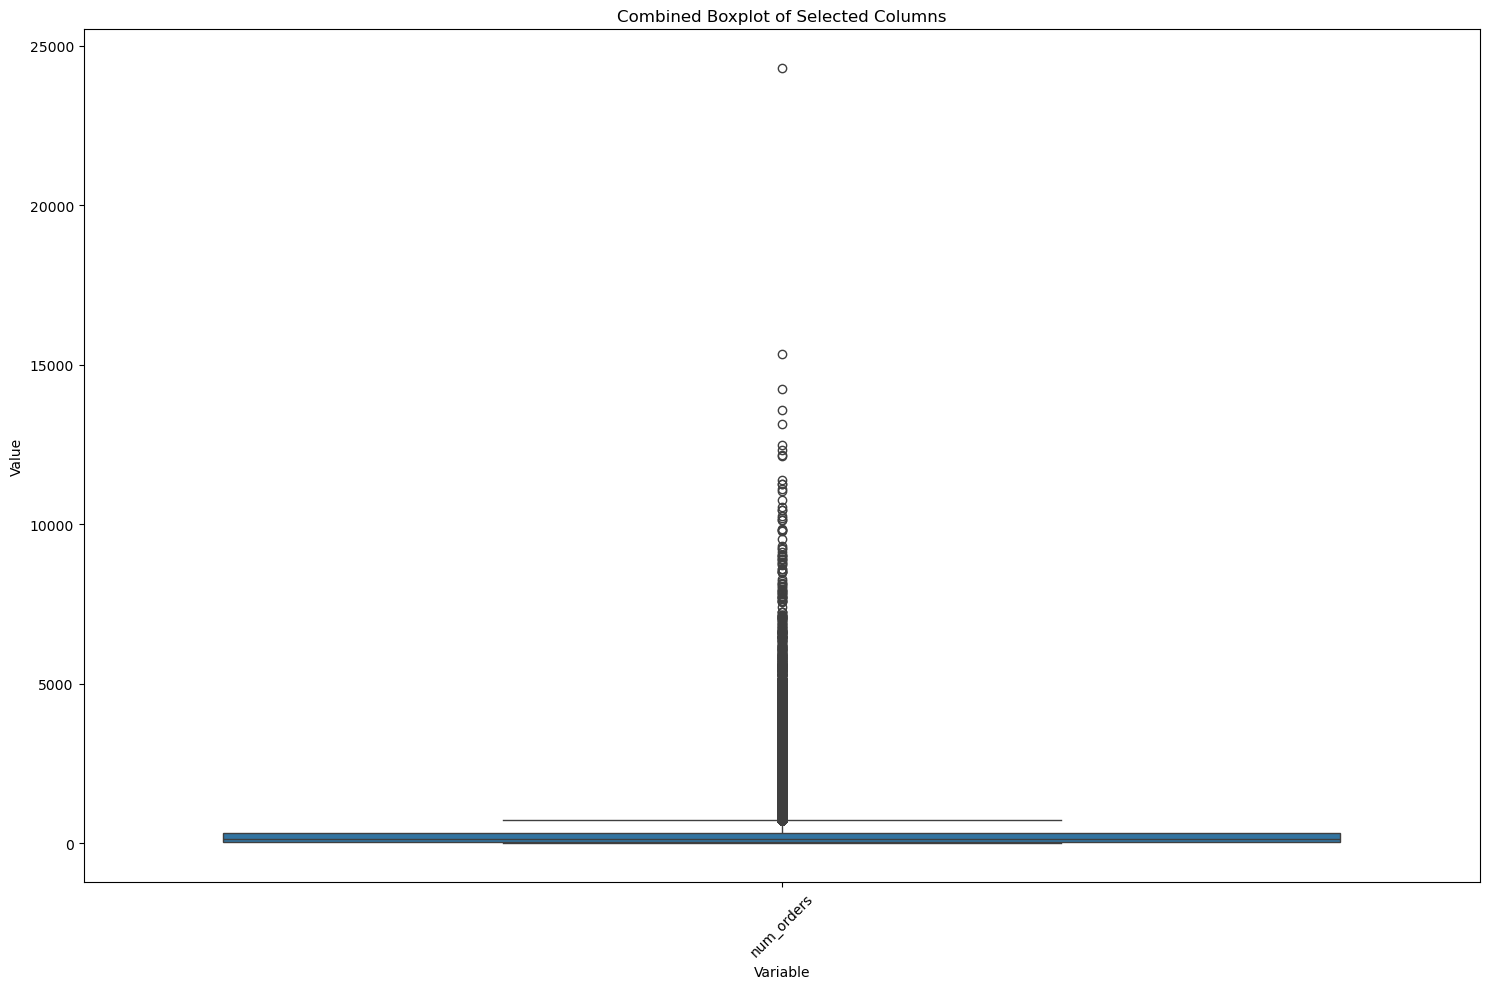

In [15]:
plot_boxplots(train, ['num_orders'])

In number of orders have been obeserved some outliers and show that it could have the extreme cases

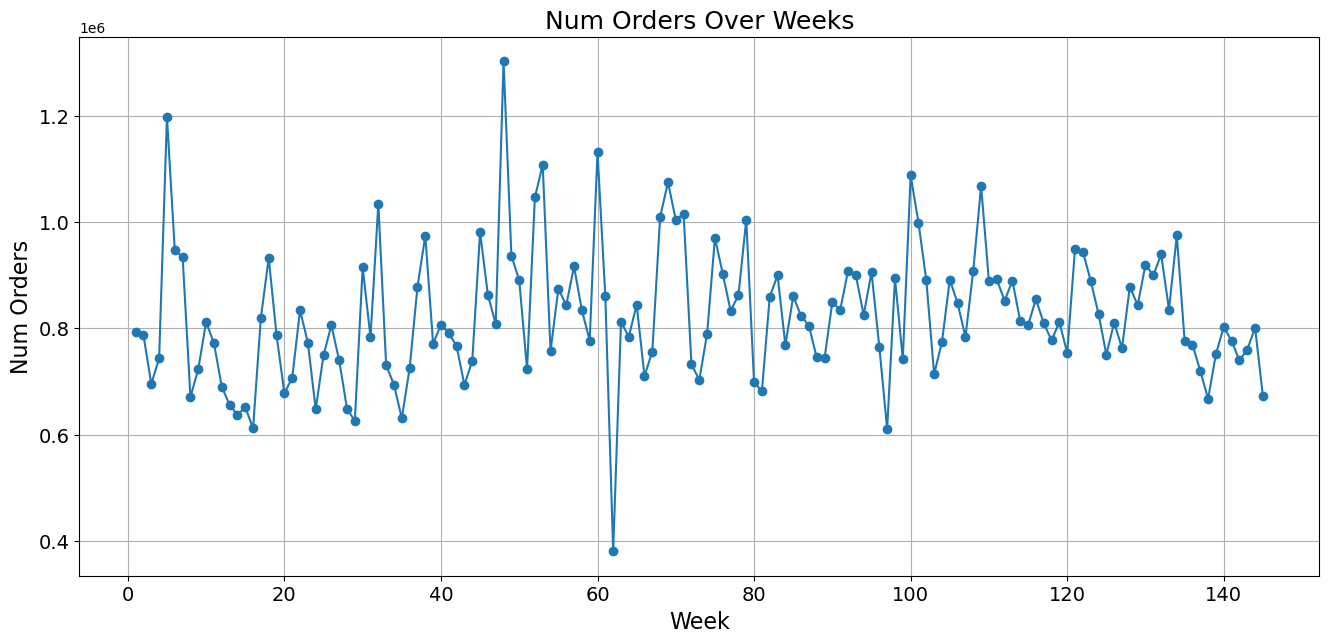

In [16]:
plt.figure(figsize=(16, 7))
weekly_data = train.groupby('week')['num_orders'].sum().reset_index()
plt.plot(weekly_data['week'], weekly_data['num_orders'], marker='o')
plt.title('Num Orders Over Weeks', fontsize=18)
plt.xlabel('Week', fontsize=16)
plt.ylabel('Num Orders', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.show()

In [17]:
center_order_summary = train.groupby('center_id')['num_orders'].sum().reset_index()
print(center_order_summary.head(10))

   center_id  num_orders
0         10     3381018
1         11     2797300
2         13     4296545
3         14     1195108
4         17     1218319
5         20     1329112
6         23     1609906
7         24     1997535
8         26      894009
9         27     2297698


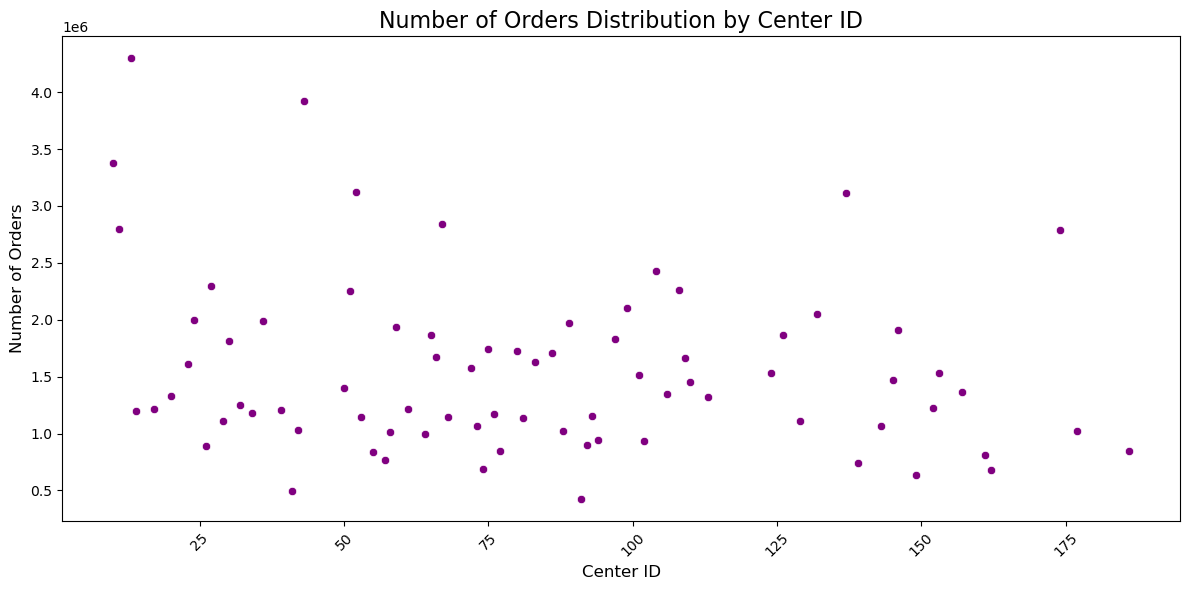

In [18]:
#Scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(x='center_id', y='num_orders', data=center_order_summary, color='purple')
plt.title('Number of Orders Distribution by Center ID', fontsize=16)
plt.xlabel('Center ID', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#The scatter plot shows a dispersed distribution of the number of orders across different center IDs.
#There doesn't appear to be a clear pattern between center ID and the number of orders, suggesting that the order volume may not be systematically related to the center's ID.

<Axes: xlabel='emailer_for_promotion', ylabel='num_orders'>

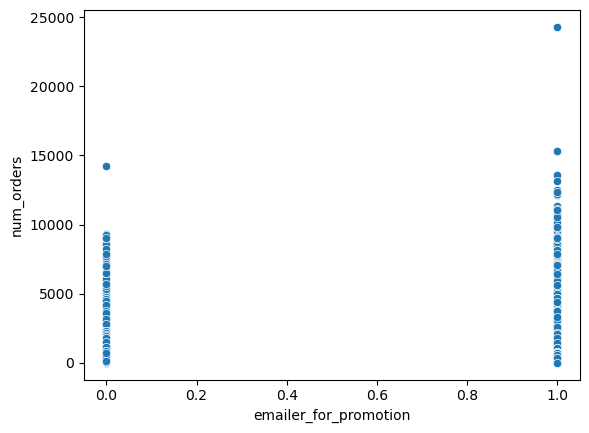

In [19]:
sns.scatterplot(data=train, x='emailer_for_promotion', y='num_orders')

This scatter plot emphasise that email promotions seems to have some effect on increasing the likelihood of high order counts

<Axes: xlabel='homepage_featured', ylabel='num_orders'>

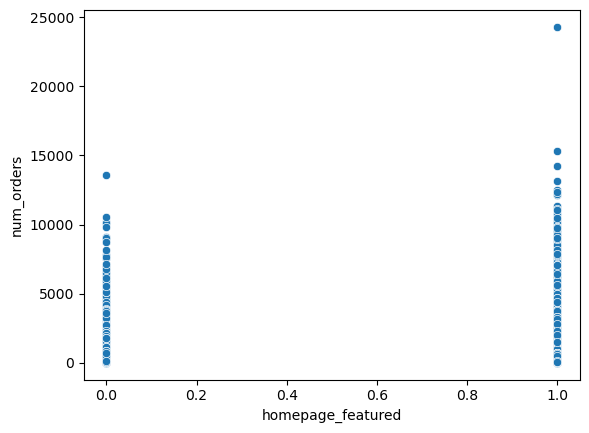

In [20]:
sns.scatterplot(data=train, x='homepage_featured', y='num_orders')

This scatter plot emphasise that email promotions seems to have some effect on increasing the likelihood of high order counts

## Inferential Analysis

### Anova

In [21]:
def anova_with_tukey(data, response, factors):

    for factor in factors:
        print(f"\n\nAnalyzing factor: {factor}")
        formula = f'{response} ~ {factor}'
        model = ols(formula, data=data).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print("\nANOVA Table: \n", anova_table)

        # Check p-value
        p_value = anova_table['PR(>F)'][factor]
        if p_value < 0.05:
            print("\nStatistically Significant ANOVA result (p < 0.05). Performing Tukey HSD test...")
            tukey = pairwise_tukeyhsd(data[response], data[factor])
            print(tukey)
        else:
            print("\nNo significant difference found (p >= 0.05). Skipping Tukey HSD test.")

In [22]:
for factor in ['week', 'center_id', 'meal_id', 'emailer_for_promotion', 'homepage_featured']:  # Example batch
    anova_with_tukey(train, 'num_orders', [factor])



Analyzing factor: week

ANOVA Table: 
                 sum_sq        df           F        PR(>F)
week      2.119649e+07       1.0  135.260395  2.925458e-31
Residual  7.154477e+10  456546.0         NaN           NaN

Statistically Significant ANOVA result (p < 0.05). Performing Tukey HSD test...
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
     1      2    0.6466    1.0  -45.4494   46.7426  False
     1      3  -31.3083 0.9723  -77.3924   14.7757  False
     1      4   -13.771    1.0  -59.8951    32.353  False
     1      5  148.1272    0.0  101.8816  194.3728   True
     1      6   61.7124    0.0   15.4134  108.0113   True
     1      7   63.3189    0.0   16.8065  109.8313   True
     1      8  -30.4625 0.9892  -77.0133   16.0883  False
     1      9  -17.7227    1.0  -63.9888   28.5433  False
     1     10   12.8176    1.0   -33.428   59.0632  False
     

Week

    · variation in num_orders that can be explain by week is 2.12e+07
    · there is about 135.26 of num_orders explain the variance of week in relative to residuals
    · because p value < 0.05, so it is the statistically significant in number_orders across different weeks, so need to do tukey test
    · TUKEY TEST
         ~ small part has the statistically sigificant while most of the part do not have the statistically significant because of the p-value < 0.05
         ~ The reject is false, which means there is no significant difference between groups, so the graph there accepts the null hypothesis. vice versa   
    · Althought the ANOVA analysis shows that week has a statistically significant impact on num_orders, the result of Tukey test show that the effect is mainly present in a small groups only.
    · Hence the effect of week on num_orders is relatively small and limited

Center ID

    · variation in num_orders that can be explain by center id is 2.03e+08
    · there is about 7.14 of num_orders explain the variance of center id in relative to residuals
    · because p value < 0.05, so it is the statistically significant in number_orders across different center id, so need to do tukey test
    · TUKEY TEST
         ~ small part does not have the statistically sigificant while most of the part have the statistically significant because of the p-value < 0.05
    · The ANOVA analysis shows that center id has a statistically significant impact on num_orders, the result of Tukey test show that the effect is mainly present in most.
    · Hence the effect of center id on num_orders is relatively big but not for all

Meal ID

    · variation in num_orders that can be explain by meal id is 8.03e+06
    · there is about 7.16e+10 of num_orders explain the variance of meal id in relative to residuals
    · because p value < 0.05, so it is the statistically significant in number_orders across different meal id, so need to do tukey test
    · TUKEY TEST
         ~ small part does not have the statistically sigificant while most of the part have the statistically significant because of the p-value < 0.05
    · The ANOVA analysis shows that center id has a statistically significant impact on num_orders, the result of Tukey test show that the effect is mainly present in most.
    · Hence the effect of meal id on num_orders is relatively big but not for all

Emailer for Promotion

    · variation in num_orders that can be explain by emailer for promotion is 5.49e+09
    · there is about 6.6e+10 of num_orders explain the variance of emailer for promotion in relative to residuals
    · because p value < 0.05, so it is the statistically significant in num_orders different emailer for promotion, so need to do tukey test
    · TUKEY TEST
         ~ all the groups part have the statistically significant because of the p-value < 0.05
    · Hence the effect of emailer for promotion on num_orders have any significant effect

Homepage Featured

    · variation in num_orders that can be explain by homepage featured is 6.21e+09
    · there is about 6.54e+10 of num_orders explain the variance of homepage featured in relative to residuals
    · because p value < 0.05, so it is the statistically significant in num_orders across different homepage featured, so need to do tukey test
    · TUKEY TEST
         ~ all the groups part have the statistically significant because of the p-value < 0.05
    · Hence the effect of homepage featured on num_orders have any significant effect

In [23]:
print(f"\n\nAnalyzing factor: checkout_price")
formula = f'{"num_orders"} ~ {"checkout_price"}'
model = ols(formula, data=train).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nANOVA Table: \n", anova_table)



Analyzing factor: checkout_price

ANOVA Table: 
                       sum_sq        df             F  PR(>F)
checkout_price  5.695586e+09       1.0  39475.968958     0.0
Residual        6.587038e+10  456546.0           NaN     NaN


In [24]:
print("\nStatistically Significant ANOVA result (p < 0.05). Performing Tukey HSD test...")
tukey = pairwise_tukeyhsd(train["num_orders"], train["checkout_price"])
with open("tukey_results(num_orders-checkout_price).txt", "w") as file:
  file.write("Tukey's HSD Test Results:")
  file.write(str(tukey))


Statistically Significant ANOVA result (p < 0.05). Performing Tukey HSD test...


In [25]:
print(f"\n\nAnalyzing factor: base_price")
formula = f'{"num_orders"} ~ {"base_price"}'
model = ols(formula, data=train).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nANOVA Table: \n", anova_table)



Analyzing factor: base_price

ANOVA Table: 
                   sum_sq        df             F  PR(>F)
base_price  3.536791e+09       1.0  23735.521967     0.0
Residual    6.802917e+10  456546.0           NaN     NaN


In [26]:
print("\nStatistically Significant ANOVA result (p < 0.05). Performing Tukey HSD test...")
tukey = pairwise_tukeyhsd(train["num_orders"], train["base_price"])
with open("tukey_results(num_orders-base_price).txt", "w") as file:
  file.write("Tukey's HSD Test Results:")
  file.write(str(tukey))


Statistically Significant ANOVA result (p < 0.05). Performing Tukey HSD test...


### KMO

In [29]:
data = pd.read_csv('./train.csv')
data_t = pd.read_csv('./test.csv')

In [30]:
# Exclude id for modeling
identifiers = [['week', 'center_id', 'meal_id']]
modeling_data = data.drop(['id', 'week', 'center_id', 'meal_id','num_orders'], axis=1)
target = data['num_orders']

In [31]:
# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
data_norm = scaler.fit_transform(modeling_data)

In [32]:
kmo_all, kmo_model = calculate_kmo(data_norm)
print('KMO Model Score:', kmo_model)
print("Individual KMO Scores per Feature:", kmo_all)

KMO Model Score: 0.42021964927011757
Individual KMO Scores per Feature: [0.43425451 0.4386738  0.27004825 0.52617521]


KMO statistic varies between 0 and 1, with higher values indicating more suitability for factor analysis:
- KMO < 0.5: Indicates the data is not suitable for factor analysis.
- 0.5 ≤ KMO < 0.6: Marginal adequacy.
- 0.6 ≤ KMO < 0.7: Adequate.
- 0.7 ≤ KMO < 0.8: Good.
- 0.8 ≤ KMO < 0.9: Great.
- KMO ≥ 0.9: Superb.

The KMO model score is 0.4202 < 0.5, indicates the data is not suitable for factor analysis

# ARIMA

In [33]:
week = data.groupby('week').sum().reset_index()['week']
num_order = data.groupby('week').sum().reset_index()['num_orders']
num_order_last = num_order.iloc[-1]
num_order_last

671926

In [34]:
# we assume the start date from this date 
start_date = '2013-01-01'

In [35]:
# Generate a date range for the number of periods 
num_order.index = pd.date_range(start=start_date, periods=len(num_order), freq='W')
print(num_order)

2013-01-06     792261
2013-01-13     787084
2013-01-20     695262
2013-01-27     743529
2013-02-03    1198675
               ...   
2015-09-13     776240
2015-09-20     739661
2015-09-27     759926
2015-10-04     801197
2015-10-11     671926
Freq: W-SUN, Name: num_orders, Length: 145, dtype: int64


In [36]:
week = train.groupby('week').sum().reset_index()['week']
num_order = train.groupby('week').sum().reset_index()['num_orders']
num_order_last= num_order.iloc[-1]
num_order_last

671926

In [37]:
# we assume the start date from this date
start_date = '2013-01-01'

In [38]:
# Generate a date range for the number of periods
num_order.index = pd.date_range(start=start_date, periods=len(num_order), freq='W')
print(num_order)

2013-01-06     792261
2013-01-13     787084
2013-01-20     695262
2013-01-27     743529
2013-02-03    1198675
               ...   
2015-09-13     776240
2015-09-20     739661
2015-09-27     759926
2015-10-04     801197
2015-10-11     671926
Freq: W-SUN, Name: num_orders, Length: 145, dtype: int64


### stationary checking

In [39]:
adf_test = adfuller(num_order)
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])
print('Critical Values:', adf_test[4])

ADF Statistic: -2.5428657726674464
p-value: 0.10538983404031188
Critical Values: {'1%': -3.479742586699182, '5%': -2.88319822181578, '10%': -2.578319684499314}


#### Explanation
- null hypothesis: data is non stationary
- adf is larger than the critical value at the confidence level 1% 5% 10%
- Since the ADF statistic is greater than all three critical values, we fail to reject the null hypothesis.
- the p value is larger than 0.05
- failed to reject the null hypothesis of non stationary
- data is non stationary

In [40]:
# Differencing
num_order_diff = num_order.diff().dropna() # first-order differencing
adf_test = adfuller(num_order_diff)

In [41]:
# check for the stationarity
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])
print('Critical Values:', adf_test[4])

ADF Statistic: -6.674500921927536
p-value: 4.500695109329098e-09
Critical Values: {'1%': -3.479742586699182, '5%': -2.88319822181578, '10%': -2.578319684499314}


#### Explanation
- null hypothesis: data is non stationary
- adf is smaller than the critical value at the confidence level 1% 5% 10%
- Since the ADF statistic is greater than all three critical values, we reject the null hypothesis.
- the p value is smaller than 0.05
- reject the null hypothesis of non stationary
- data is stationary

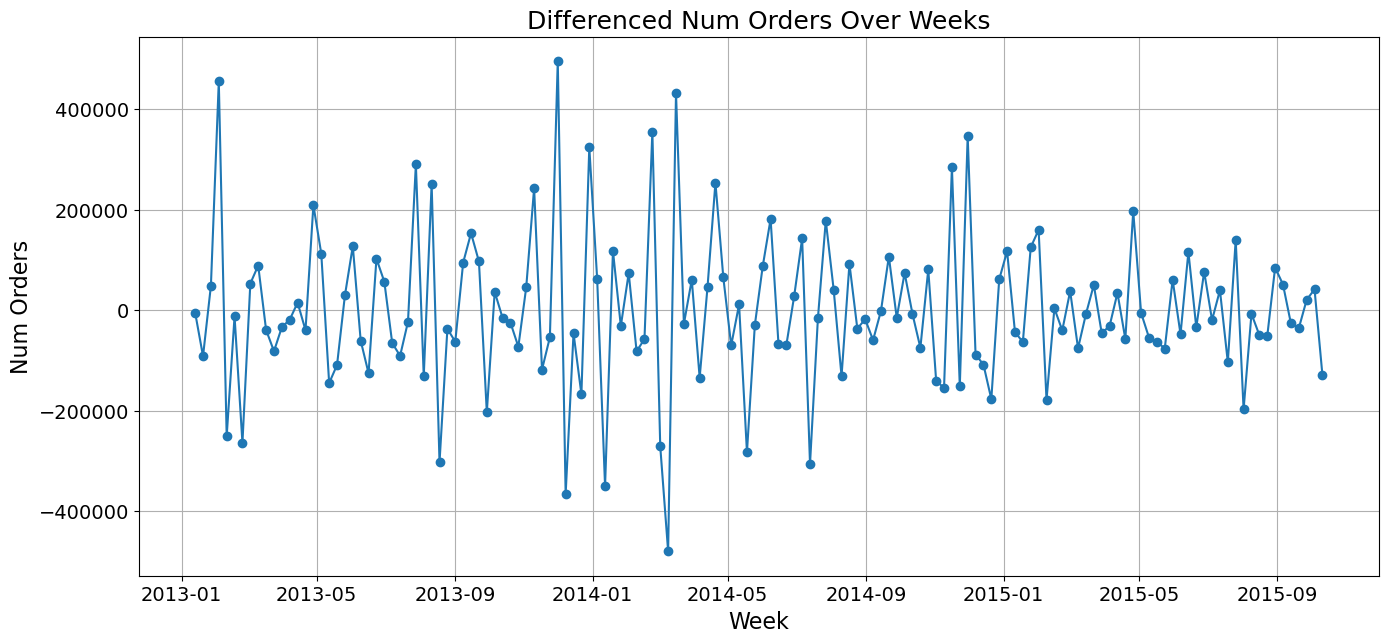

In [42]:
plt.figure(figsize=(16, 7))
plt.plot(num_order_diff, marker='o')
plt.title('Differenced Num Orders Over Weeks', fontsize=18)
plt.xlabel('Week', fontsize=16)
plt.ylabel('Num Orders', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.show()

### ACF and PACF

Text(0.5, 1.0, 'Autocorrelation Function (ACF)')

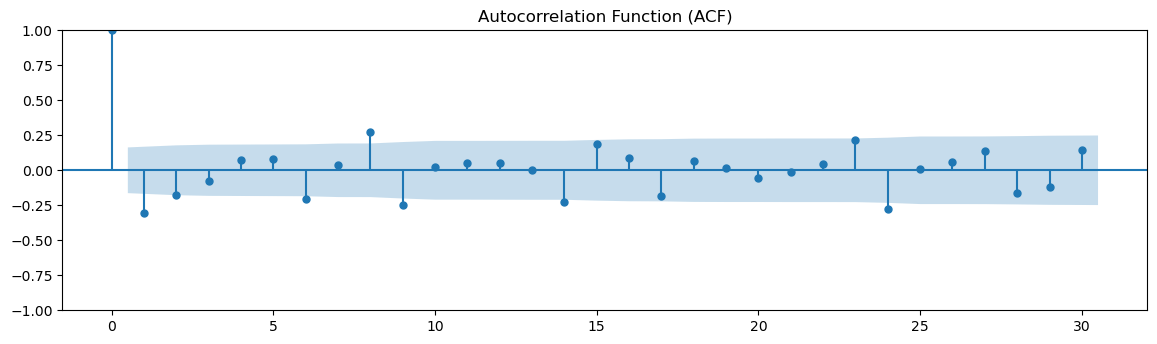

In [43]:
plt.figure(figsize=(14,8))

# ACF plot
plt.subplot(2,1,1)
plot_acf(num_order_diff, lags=30, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

In [44]:
from statsmodels.tsa.stattools import acf, pacf

n = len(num_order_diff)
threshold =1.96/np.sqrt(n)

acf_values = acf(num_order_diff, nlags=20)
significant_q_values = sum(abs(acf_values[1:]) > threshold)

print('number of significan q (ACF) value: ', significant_q_values )

number of significan q (ACF) value:  8


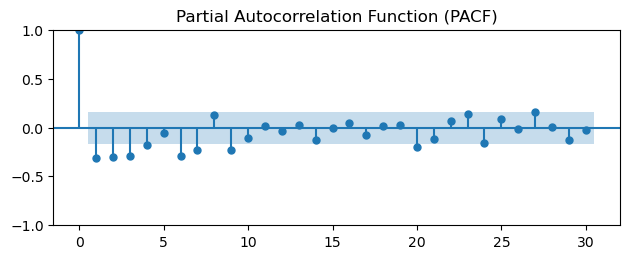

In [45]:
# PACF plot
plt.subplot(2,1,2)
plot_pacf(num_order_diff, lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [46]:
n = len(num_order_diff)
threshold =1.96/np.sqrt(n)
pacf_values = pacf(num_order_diff, nlags=20)
significant_p_values = sum(abs(pacf_values[1:]) > threshold)

print('number of significan p (PACF) value: ', significant_p_values)

number of significan p (PACF) value:  8


In [47]:
p = 8
d = 1
q = 8

In [48]:
train_size = int(len(num_order_diff) * 0.8)
train, test = num_order_diff[:train_size], num_order_diff[train_size:]

In [49]:
model = ARIMA(train,order= (p,d,q))
result = model.fit()

C:\Users\yihui\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\yihui\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [50]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             num_orders   No. Observations:                  115
Model:                 ARIMA(8, 1, 8)   Log Likelihood               -1498.213
Date:                Wed, 04 Dec 2024   AIC                           3030.426
Time:                        21:36:30   BIC                           3076.942
Sample:                    01-13-2013   HQIC                          3049.304
                         - 03-22-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6568      7.727     -0.214      0.830     -16.801      13.488
ar.L2         -2.0269     12.128     -0.167      0.867     -25.798      21.744
ar.L3         -1.5877     13.747     -0.115      0.908     -28.532      25.357
ar.L4         -1.0225      9.768     -0.105      0.917     -20.167      18.122
ar.L5         -0.2677      5.510     -0.049      0.961     -11.067      10.532
ar.L6         -0.3060      0.948     -0.323      0.747      -2.164       1.552
ar.L7         -0.1564      1.977     -0.079      0.937      -4.031       3.718
ar.L8         -0.0078      1.323     -0.006      0.995      -2.600       2.584
ma.L1          0.0703      7.757      0.009      0.993     -15.134      15.274
ma.L2         -0.2927      1.403     -0.209      0.835      -3.042       2.457
ma.L3         -1.0436      3.179     -0.328      0.743      -7.275       5.188
ma.L4         -0.4115      7.888     -0.052      0.958     -15.872      15.049
ma.L5         -0.1966      2.554     -0.077      0.939      -5.203       4.810
ma.L6          0.7568      0.560      1.351      0.177      -0.341       1.854
ma.L7          0.0237      6.216      0.004      0.997     -12.159      12.207
ma.L8          0.1032      1.256      0.082      0.935      -2.359       2.565
sigma2      1.556e+10   1.69e-08   9.23e+17      0.000    1.56e+10    1.56e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                55.58
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.70
Prob(H) (two-sided):                  0.38   Kurtosis:                         6.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.38e+35. Standard errors may be unstable.
"""

Ljung-Box Test (Q): A p-value of 0.98 suggests that there is no significant autocorrelation in the residuals at lag 1, meaning that the model is capturing the time dependencies well at least at this lag.
Jarque-Bera Test: A significant p-value (0.00) indicates that the residuals are not normally distributed, which may be a concern. This could suggest that the model's residuals are skewed or have heavy tails.
Heteroskedasticity Test: A significant p-value (0.00) indicates that there is likely heteroskedasticity, meaning that the variance of the residuals is not constant over time.

In [51]:
# Make predictions on the validation set
predictions = result.predict(start=test.index[0],end=test. index[-1], typ='levels')

C:\Users\yihui\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [52]:
rmse = sqrt(mean_squared_error(test, predictions))
print(rmse)


104871.17344992614


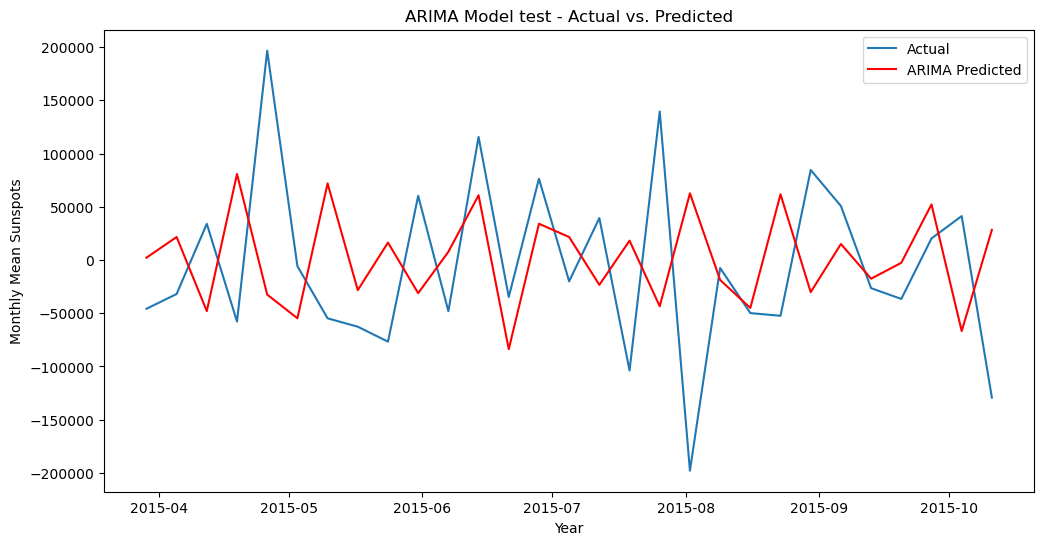

In [53]:
plt.figure(figsize=(12,6))
plt.plot(test, label='Actual')
plt.plot(predictions, color='red', label='ARIMA Predicted')
plt.title('ARIMA Model test - Actual vs. Predicted')
plt.xlabel('Year')
plt.ylabel('Monthly Mean Sunspots')
plt.legend()
plt.show()

In [54]:
# Step 1: Fit ARIMA model
model = ARIMA(train, order=(p, d, q))
arima_fit = model.fit()

# Generate ARIMA predictions
arima_predictions = arima_fit.predict(start=test.index[0], end=test.index[-1], typ='levels')

# Step 2: Get the residuals (errors between actual and ARIMA predictions)
residuals = test - arima_predictions

C:\Users\yihui\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\yihui\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yihui\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [55]:
# Step 3: Train LSTM on residuals
# Prepare residuals for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
residuals_scaled = scaler.fit_transform(residuals.values.reshape(-1, 1))

In [56]:
# Prepare data for LSTM: create sequences of previous timesteps (X) to predict next value (y)
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 1  # Number of previous timesteps to use for prediction
X_residuals, y_residuals = create_dataset(residuals_scaled, look_back)

# Reshape X for LSTM input
X_residuals = X_residuals.reshape((X_residuals.shape[0], X_residuals.shape[1], 1))

In [57]:
# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=False, input_shape=(look_back, 1)))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
# Train the LSTM model
lstm_model.fit(X_residuals, y_residuals, epochs=10, batch_size=1, verbose=2)
# Step 4: Make LSTM predictions on residuals for the validation period
lstm_predictions = lstm_model.predict(X_residuals)
lstm_predictions = scaler.inverse_transform(lstm_predictions)  # Convert back to original scale

NameError: name 'Sequential' is not defined

In [ ]:
# Align ARIMA and LSTM predictions length
if len(arima_predictions) > len(lstm_predictions.flatten()):
    arima_predictions = arima_predictions[:len(lstm_predictions.flatten())]
elif len(lstm_predictions.flatten()) > len(arima_predictions):
    lstm_predictions = lstm_predictions.flatten()[:len(arima_predictions)]

In [ ]:
# Step 7: Combine ARIMA and LSTM predictions for the test set
combined_test_predictions = arima_predictions + lstm_predictions.flatten()

# Step 10: Print the ARIMA and LSTM predictions
print("ARIMA Test Predictions:")
print(arima_predictions)

print("LSTM Test Predictions:")
print(lstm_predictions.flatten())

In [ ]:
# Step 5: Combine ARIMA and LSTM predictions
combined_predictions = arima_predictions + lstm_predictions.flatten()

In [ ]:
# Step 6: Calculate RMSE for the hybrid model
rmse = sqrt(mean_squared_error(test[:len(combined_predictions)], combined_predictions))
print(f'Hybrid Model RMSE: {rmse}')

Explanation
ARIMA is good at linear trends and seasonality.
LSTM is effective at learning nonlinear and complex patterns.
LSTM can capture nonlinear dependencies or residual errors that ARIMA cannot.
we combine the output of both model. with the assumption that adding arima (captured trend and seasonality), lstm (future capture the part ARIMA miss)
we give equal weightage to both the arima and lstm predicted value in the experiment with the assumption that both models are equally good predictors

In [ ]:
actual_values = test[:len(combined_test_predictions)]
# Assuming `validation.index` represents the time series dates
# Ensure ARIMA and LSTM predictions are in the same length as validation data
dates = test.index[:len(combined_test_predictions)]

# Create a DataFrame to organize predictions
predictions_df = pd.DataFrame({
    "Dates": dates,
    "Actual": actual_values,
    "ARIMA": arima_predictions,
    "LSTM": lstm_predictions.flatten(),
    "Combined": combined_predictions
}).set_index("Dates")

# Plotting
plt.figure(figsize=(12, 6))
#plt.plot(predictions_df.index, predictions_df["Actual"], label="Actual Values")
plt.plot(predictions_df.index, predictions_df["ARIMA"], label="ARIMA Predictions", alpha=0.5, color="black", linestyle='--')
plt.plot(predictions_df.index, predictions_df["LSTM"], label="LSTM Predictions", alpha=0.5, color="green", linestyle='--')
plt.plot(predictions_df.index, predictions_df["Combined"], label="Combined Predictions", color="red")

# Adding labels, legend, and title
plt.title("ARIMA, LSTM, and Combined Predictions [Test Data]]")
plt.xlabel("Date")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# Create a DataFrame to organize predictions and real values
predictions_df = pd.DataFrame({
    "Dates": dates,
    "Actual": actual_values,
    "Combined": combined_test_predictions
}).set_index("Dates")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(predictions_df.index, predictions_df["Actual"], label="Actual Values")
plt.plot(predictions_df.index, predictions_df["Combined"], label="Combined Predictions", color="red")

# Adding labels, legend, and title
plt.title("Combined Predictions and Actual Values [Test Data]")
plt.xlabel("Date")
plt.ylabel("Predicted / Actual Values")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# Step 1: Forecast next 10 steps with ARIMA
forecast_steps = 10

forecast_index = pd.date_range(num_order.index[-1], periods=forecast_steps, freq='W')
arima_forecast = arima_fit.get_forecast(steps=forecast_steps, index=forecast_index)
arima_forecast_diff = arima_forecast.predicted_mean

# Step 2: Forecast residuals using LSTM
# Use the last `look_back` residuals to start predicting future residuals
last_residuals = residuals_scaled[-look_back:]
X_future_residuals = last_residuals.reshape(1, look_back, 1)

future_residuals = []

# Predict residuals iteratively
for _ in range(forecast_steps):
    pred = lstm_model.predict(X_future_residuals)  # Predict next residual
    future_residuals.append(pred[0][0])  # Append the predicted residual
    # Slide the window
    X_future_residuals = np.concatenate([X_future_residuals[:, 1:, :], pred.reshape(1, 1, 1)], axis=1)

# Inverse scale the residuals to original scale
future_residuals = scaler.inverse_transform(np.array(future_residuals).reshape(-1, 1)).flatten()

# ARIMA forecast acutal value
last_actual_value = num_order_last  # Replace this with the actual last observed value
forecast_index = pd.date_range(num_order.index[-1], periods=forecast_steps, freq='W')
arima_predicted_values = arima_forecast_diff.cumsum() + last_actual_value # Get the scalar value

# Step 3: Combine ARIMA forecasts and residuals
future_predictions = arima_predicted_values + future_residuals

future_predictions = pd.Series(future_predictions)  # Ensure predictions are a Pandas Series

# Step 4: Print the future predictions
print("Future Predictions (Hybrid Model):")
print(future_predictions)

In [ ]:
# Assuming `last_actual_value` is the last observed value from your dataset
last_actual_value = num_order_last  # Replace this with the actual last observed value
future_predictions = pd.Series(future_predictions)  # Ensure predictions are a Pandas Series

forecast_index = pd.date_range(num_order.index[-1], periods=forecast_steps, freq='W')

predicted_values = future_predictions.cumsum() + last_actual_value # Get the scalar value
print(predicted_values)

In [ ]:
# Plot the real predicted values
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(future_predictions, label="Real Predicted Values", color="red")
plt.title("Real Predicted Values Based on Combined ARIMA + LSTM")
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Plot the original series
plt.figure(figsize=(20,6))
plt.plot(num_order, label='Original')

# Plot the predicted values
plt.plot(future_predictions, color='red', label='Predicted')

plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.title('Number of Order')
plt.legend()
plt.show()

### Stationary Checking

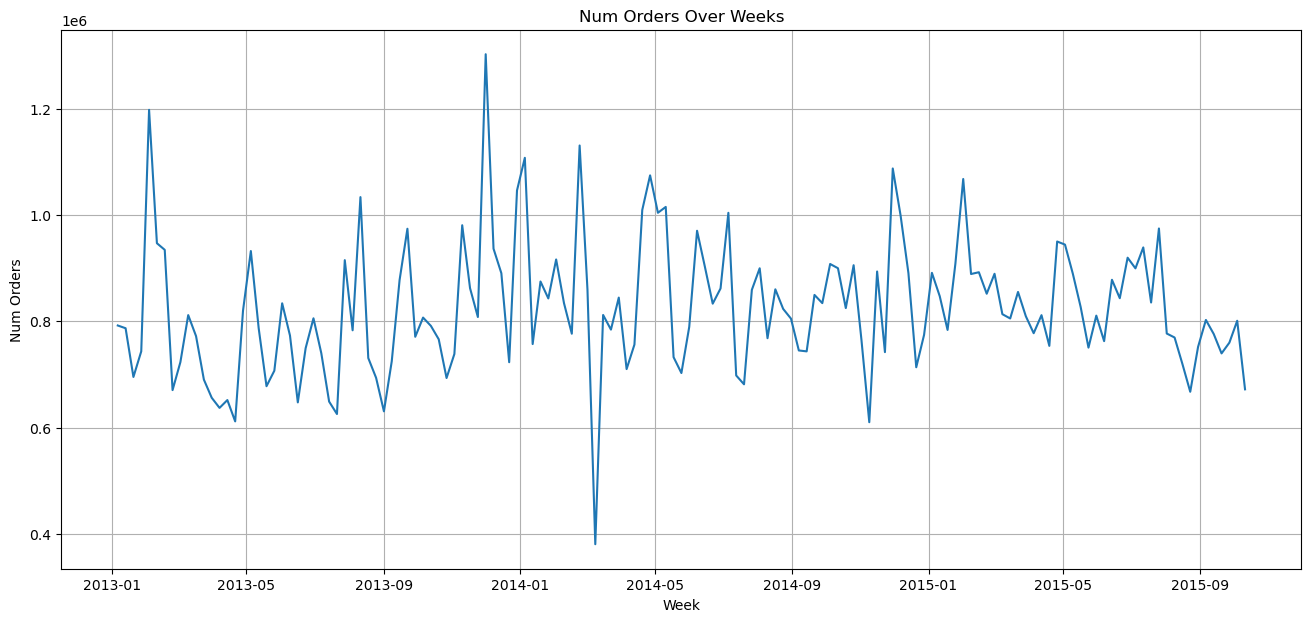

In [58]:
plt.figure(figsize=(16, 7))
plt.plot(num_order)
plt.title('Num Orders Over Weeks')
plt.xlabel('Week')
plt.ylabel('Num Orders')
plt.grid(True)
plt.show()

In [59]:
adf_test = adfuller(num_order)
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])
print('Critical Values:', adf_test[4])

ADF Statistic: -2.5428657726674464
p-value: 0.10538983404031188
Critical Values: {'1%': -3.479742586699182, '5%': -2.88319822181578, '10%': -2.578319684499314}


#### Explanation
- null hypothesis: data is non stationary 
- adf is larger than the critical value at the confidence level 1% 5% 10%
- Since the ADF statistic is greater than all three critical values, we fail to reject the null hypothesis.
- the p value is larger than 0.05
- failed to reject the null hypothesis of non stationary
- data is non stationary 

In [60]:
# Differencing 
num_order_diff = num_order.diff().dropna() # first-order differencing
adf_test = adfuller(num_order_diff)

In [61]:
# check for the stationarity 
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])
print('Critical Values:', adf_test[4])

ADF Statistic: -6.674500921927536
p-value: 4.500695109329098e-09
Critical Values: {'1%': -3.479742586699182, '5%': -2.88319822181578, '10%': -2.578319684499314}


#### Explanation
- null hypothesis: data is non stationary
- adf is smaller than the critical value at the confidence level 1% 5% 10%
- Since the ADF statistic is greater than all three critical values, we reject the null hypothesis.
- the p value is smaller than 0.05
- reject the null hypothesis of non stationary
- data is stationary

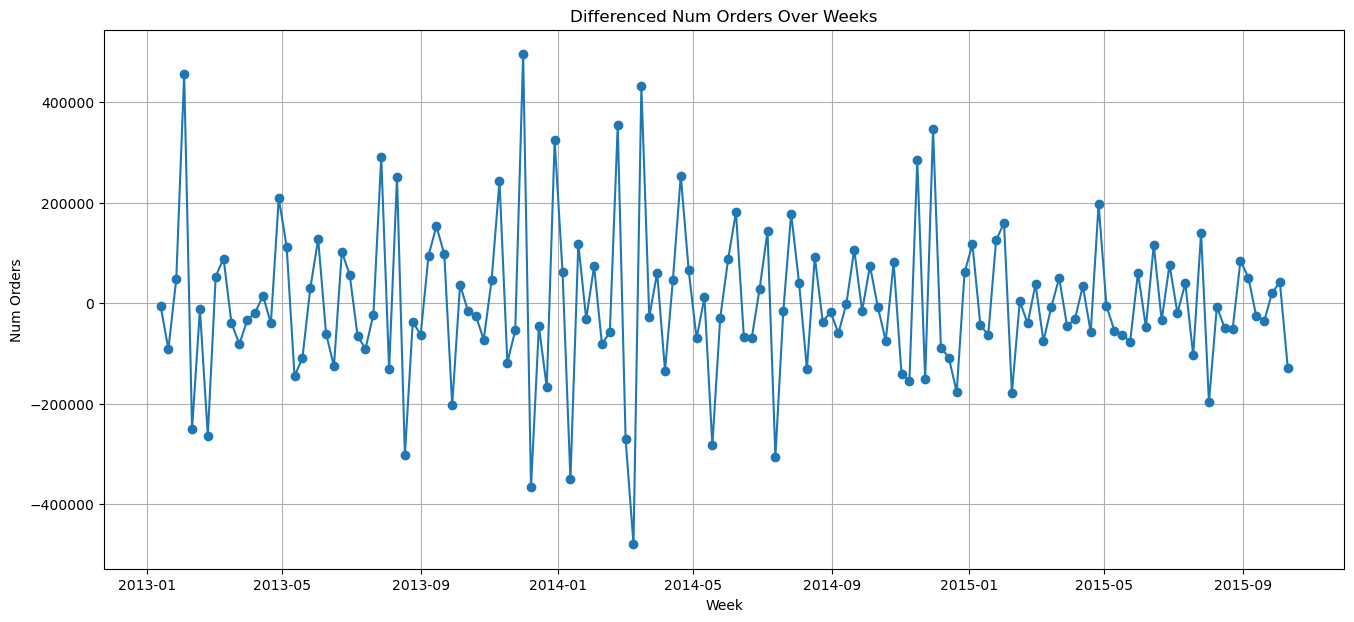

In [62]:
plt.figure(figsize=(16, 7))
plt.plot(num_order_diff, marker='o')
plt.title('Differenced Num Orders Over Weeks')
plt.xlabel('Week')
plt.ylabel('Num Orders')
plt.grid(True)
plt.show()

### ACF and PACF

Text(0.5, 1.0, 'PACF for Num of Order')

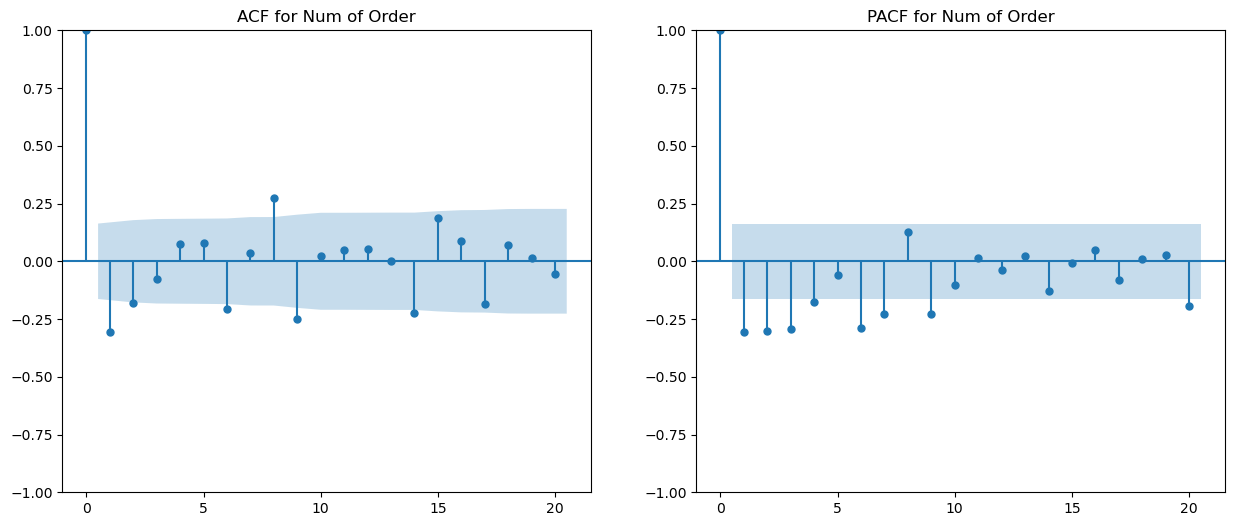

In [63]:
# Plot ACF and PACF for differenced data
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_acf(num_order_diff, ax=axes[0], lags=20)
plot_pacf(num_order_diff, ax=axes[1], lags=20)
axes[0].set_title("ACF for Num of Order")
axes[1].set_title("PACF for Num of Order")

In [64]:
n = len(num_order_diff)
threshold =1.96/np.sqrt(n) 

pacf_values = pacf(num_order_diff, nlags=20)
significant_p_values = sum(abs(pacf_values[1:]) > threshold)
print('number of significan p (PACF) value: ', significant_p_values)

acf_values = acf(num_order_diff, nlags=20)
significant_q_values = sum(abs(acf_values[1:]) > threshold)
print('number of significan q (ACF) value: ', significant_q_values )

number of significan p (PACF) value:  8
number of significan q (ACF) value:  8


In [65]:
p = 8
d = 1
q = 8

In [66]:
train_size = int(len(num_order_diff) * 0.8)
train, test = num_order_diff[:train_size], num_order_diff[train_size:]

In [67]:
model_arima = ARIMA(train,order= (p,d,q))
model_arima_fit = model_arima.fit()

C:\Users\yihui\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\yihui\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [68]:
model_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             num_orders   No. Observations:                  115
Model:                 ARIMA(8, 1, 8)   Log Likelihood               -1498.213
Date:                Wed, 04 Dec 2024   AIC                           3030.426
Time:                        21:36:47   BIC                           3076.942
Sample:                    01-13-2013   HQIC                          3049.304
                         - 03-22-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6568      7.727     -0.214      0.830     -16.801      13.488
ar.L2         -2.0269     12.128     -0.167      0.867     -25.798      21.744
ar.L3         -1.5877     13.747     -0.115      0.908     -28.532      25.357
ar.L4         -1.0225      9.768     -0.105      0.917     -20.167      18.122
ar.L5         -0.2677      5.510     -0.049      0.961     -11.067      10.532
ar.L6         -0.3060      0.948     -0.323      0.747      -2.164       1.552
ar.L7         -0.1564      1.977     -0.079      0.937      -4.031       3.718
ar.L8         -0.0078      1.323     -0.006      0.995      -2.600       2.584
ma.L1          0.0703      7.757      0.009      0.993     -15.134      15.274
ma.L2         -0.2927      1.403     -0.209      0.835      -3.042       2.457
ma.L3         -1.0436      3.179     -0.328      0.743      -7.275       5.188
ma.L4         -0.4115      7.888     -0.052      0.958     -15.872      15.049
ma.L5         -0.1966      2.554     -0.077      0.939      -5.203       4.810
ma.L6          0.7568      0.560      1.351      0.177      -0.341       1.854
ma.L7          0.0237      6.216      0.004      0.997     -12.159      12.207
ma.L8          0.1032      1.256      0.082      0.935      -2.359       2.565
sigma2      1.556e+10   1.69e-08   9.23e+17      0.000    1.56e+10    1.56e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                55.58
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.70
Prob(H) (two-sided):                  0.38   Kurtosis:                         6.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.38e+35. Standard errors may be unstable.
"""

Ljung-Box Test (Q): A p-value of 0.98 suggests that there is no significant autocorrelation in the residuals at lag 1, meaning that the model is capturing the time dependencies well at least at this lag.

Jarque-Bera Test: A significant p-value (0.00) indicates that the residuals are not normally distributed, which may be a concern. This could suggest that the model's residuals are skewed or have heavy tails.

Heteroskedasticity Test: A significant p-value (0.00) indicates that there is likely heteroskedasticity, meaning that the variance of the residuals is not constant over time.

In [69]:
# Make predictions on the validation set
predictions = model_arima_fit.predict(start=test.index[0],end=test. index[-1], typ='levels')

C:\Users\yihui\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [70]:
rmse = np.sqrt(mean_squared_error(test, predictions))
print('RMSE:', rmse)

mae = mean_absolute_error(test, predictions)
print('MAE:', mae)

mape = mean_absolute_percentage_error(test, predictions)
print('MAPE:', mape)

RMSE: 104871.17344992614
MAE: 84105.35070187681
MAPE: 1.597568470837585


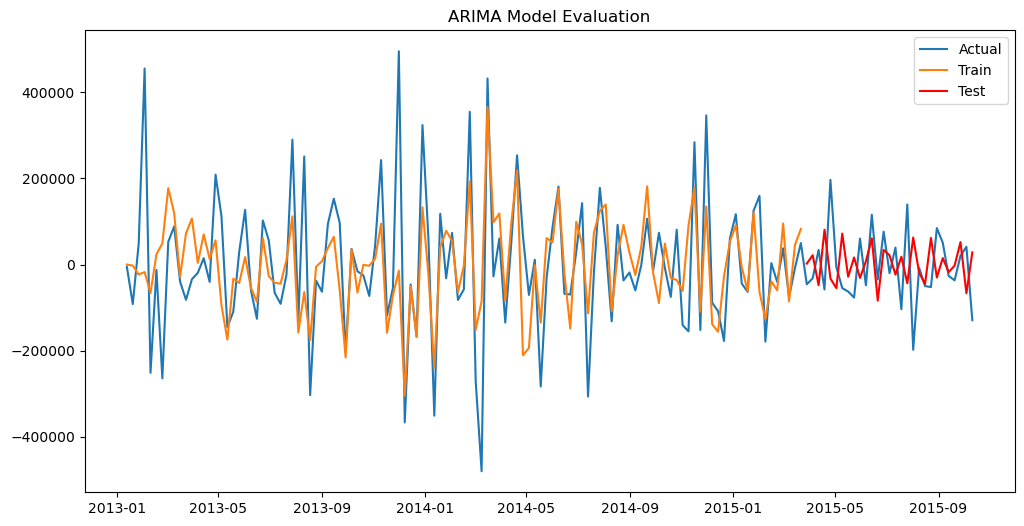

In [71]:
# Plot the train value and test value to evaluate the model
plt.figure(figsize=(12,6))
plt.plot(num_order_diff, label='Actual')
plt.plot(model_arima_fit.fittedvalues, label='Train')
plt.plot(predictions, color='red', label='Test')
plt.title('ARIMA Model Evaluation')
plt.legend()
plt.show()

### Forecast

In [72]:
# Forecast the rest 50 weeks
forecast_steps = 50
forecast_index = pd.date_range(num_order.index[-1], periods=forecast_steps, freq='W')
forecast = model_arima_fit.get_forecast(steps=forecast_steps, index=forecast_index)
forecast_diff = forecast.predicted_mean

# Get the last observed value from the original (non-differenced) data
last_value = num_order_last

# Reverse the diffencing
predicted_values = forecast_diff.cumsum() + last_value

# Print the predicted values
print(predicted_values)

2015-10-11    674122.999482
2015-10-18    695738.066794
2015-10-25    647744.051047
2015-11-01    728569.836996
2015-11-08    696089.874265
2015-11-15    641353.901191
2015-11-22    713314.531165
2015-11-29    685015.034006
2015-12-06    701373.419760
2015-12-13    670212.150732
2015-12-20    677920.320929
2015-12-27    738768.068063
2016-01-03    655013.853621
2016-01-10    689088.503127
2016-01-17    710665.794515
2016-01-24    687304.224268
2016-01-31    705477.086214
2016-02-07    662022.765641
2016-02-14    724701.571490
2016-02-21    705949.573436
2016-02-28    660925.551814
2016-03-06    722652.891842
2016-03-13    692441.543293
2016-03-20    707460.197438
2016-03-27    689904.889732
2016-04-03    687287.717902
2016-04-10    739509.690894
2016-04-17    672759.338836
2016-04-24    701094.222920
2016-05-01    719116.148129
2016-05-08    693927.820254
2016-05-15    717410.467304
2016-05-22    679971.059544
2016-05-29    726221.495369
2016-06-05    716050.398629
2016-06-12    677470

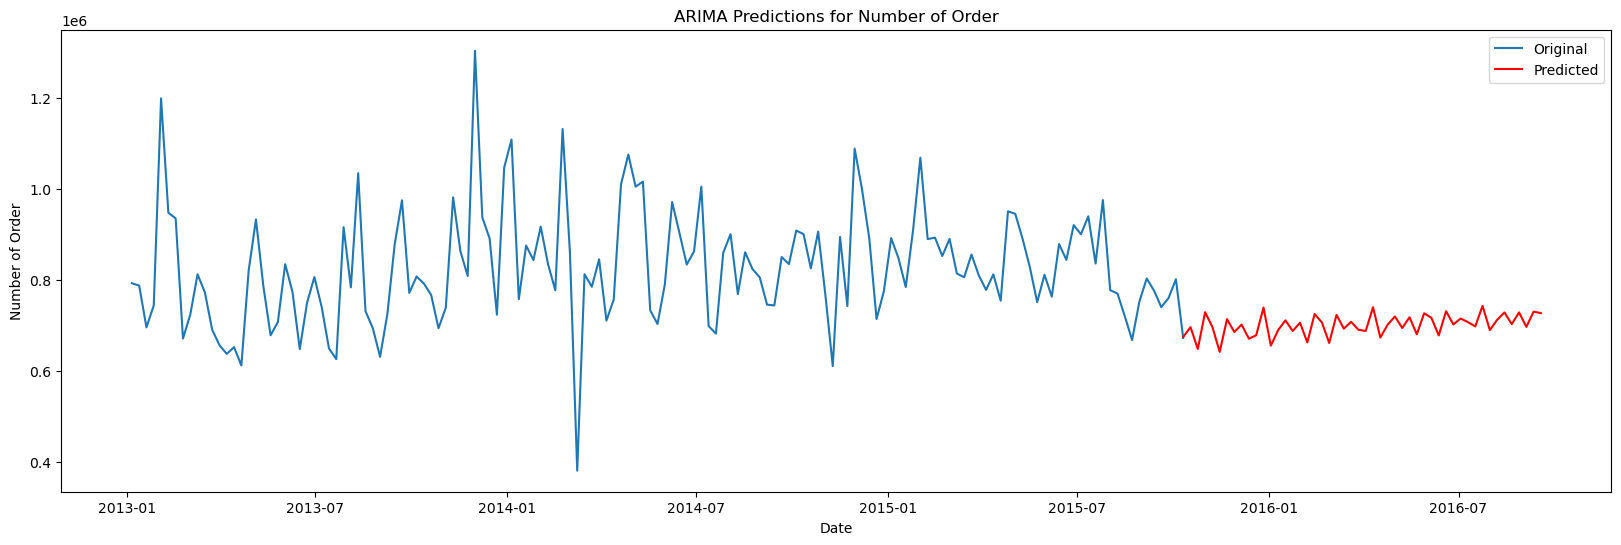

In [73]:
# Plot the original series
plt.figure(figsize=(20,6))
plt.plot(num_order, label='Original')

# Plot the predicted values
plt.plot(predicted_values, color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Number of Order')
plt.title('ARIMA Predictions for Number of Order')
plt.legend()
plt.show()

# Ridge Regression

In [75]:
correlation = data.corr()
print(correlation['num_orders'].sort_values(ascending=False))

num_orders               1.000000
homepage_featured        0.294490
emailer_for_promotion    0.277147
meal_id                  0.010597
id                       0.000702
week                    -0.017210
center_id               -0.053035
base_price              -0.222306
checkout_price          -0.282108
Name: num_orders, dtype: float64


In [76]:
# Example data (replace 'modeling_data' with your feature dataframe)
features = modeling_data # Exclude the target variable
features = add_constant(features)  # Add constant term for intercept

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = features.columns
vif_data['VIF'] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print(vif_data)

                 Feature        VIF
0                  const   6.025926
1         checkout_price  16.048490
2             base_price  16.466341
3  emailer_for_promotion   1.527282
4      homepage_featured   1.234982


In [79]:
X = data[['checkout_price', 'base_price', 'emailer_for_promotion', 'homepage_featured']]
y = data['num_orders']
# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#Standardize the features using the StandardScaler function
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [80]:
# Ridge regression to train the model with automatic alpha selection
ridge_cv = RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10, 100], cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)
y_pred = ridge_cv.predict(X_test)
# Get the best alpha and calculate performance metrics
best_alpha = ridge_cv.alpha_
best_mse = mean_squared_error(y_test, y_pred)
best_r2 = r2_score(y_test, y_pred)
print("Best Alpha:", best_alpha)
print("Best Mean Squared Error:", best_mse)
print("Best R-squared (R2) Score:", best_r2)

Best Alpha: 100.0
Best Mean Squared Error: 122970.21555367527
Best R-squared (R2) Score: 0.19381488197545094


In [81]:
# Get coefficients for ridge regression
ridge_coefs = ridge_cv.coef_

# Create a DataFrame for comparison
ridge_values = pd.DataFrame({
    'Feature': modeling_data.columns,  # Use column names from the DataFrame
    'Ridge Regression Coefficient': ridge_coefs
})

print(ridge_values)

                 Feature  Ridge Regression Coefficient
0         checkout_price                    -52.769540
1             base_price                    -57.491260
2  emailer_for_promotion                     87.734501
3      homepage_featured                     83.026944


Strong Non-linearity or Complex Relationships:

the relationship between the features and the target variable is non-linear or complex, Ridge regression might not be enough to capture the underlying pattern, even with strong regularization. In such cases, regularization might not fully shrink coefficients, as it is trying to preserve model complexity.

Solution:

Consider trying non-linear models (e.g., decision trees, random forests, or gradient boosting) or adding polynomial features to capture non-linear relationships.

# Regression Model

## XGBoost

In [97]:
# Separate independent variables (X) and target variable (y)
X = modeling_data
y = data['num_orders']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
# Create and fit an XGBoost model
model_xgb = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=250,           # Number of boosting rounds
    learning_rate=0.1,          # Learning rate (eta)
    max_depth=6,                # Maximum depth of each tree
    subsample=1.0,              # Subsample ratio of the training instance
    colsample_bytree=1.0,       # Subsample ratio of columns for each tree
    random_state=42             # Seed for reproducibility
)
model_xgb.fit(x_train, y_train);

In [99]:
# Predict using the trained model
y_pred_xgb = model_xgb.predict(x_test)

In [100]:
MSE = mean_squared_error(y_test, y_pred_xgb)
MAE = mean_absolute_error(y_test, y_pred_xgb)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, y_pred_xgb)

# Print the metrics
print("Mean Squared Error (MSE):", MSE)
print("Mean Absolute Error (MAE):", MAE)
print("Root Mean Squared Error (RMSE):", RMSE)
print("R-squared:", r2)

Mean Squared Error (MSE): 75829.26670236034
Mean Absolute Error (MAE): 153.39683839839478
Root Mean Squared Error (RMSE): 275.3711435542227
R-squared: 0.5028680233590899


## Decision Tree Regressor

In [101]:
# Initialize the Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(max_depth=12, random_state=42)

# Train the model on the training data
dt_regressor.fit(X_train, y_train);

In [102]:
# Predict on test data
y_pred_dt = dt_regressor.predict(X_test)

In [103]:
MSE = mean_squared_error(y_test, y_pred_dt)
MAE = mean_absolute_error(y_test, y_pred_dt)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, y_pred_dt)

# Print the metrics
print("Mean Squared Error (MSE):", MSE)
print("Mean Absolute Error (MAE):", MAE)
print("Root Mean Squared Error (RMSE):", RMSE)
print("R-squared:", r2)

Mean Squared Error (MSE): 82720.92625621436
Mean Absolute Error (MAE): 153.2513222621274
Root Mean Squared Error (RMSE): 287.6124584509759
R-squared: 0.45768673010207606


## Random Forest Regressor

In [104]:
# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=12, random_state=42)

# Train the model on the training data
rf_regressor.fit(X_train, y_train);

In [105]:
# Predict on test data
y_pred_rf = rf_regressor.predict(X_test)

In [106]:
MSE = mean_squared_error(y_test, y_pred_rf)
MAE = mean_absolute_error(y_test, y_pred_rf)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, y_pred_rf)

# Print the metrics
print("Mean Squared Error (MSE):", MSE)
print("Mean Absolute Error (MAE):", MAE)
print("Root Mean Squared Error (RMSE):", RMSE)
print("R-squared:", r2)

Mean Squared Error (MSE): 76202.52825743273
Mean Absolute Error (MAE): 150.80558592373464
Root Mean Squared Error (RMSE): 276.0480542540243
R-squared: 0.5004209437189089


### Forecast

The reggresion model with best performance which is XGBoost model is used to predict the future number of orders.

In [107]:
data_t = pd.read_csv('./test.csv')
# Drop unnecessary columns (e.g., 'id', 'week', 'center_id', 'meal_id')
future_data = data_t.drop(['id', 'week', 'center_id', 'meal_id'], axis=1)

y_pred_xgb_future = model_xgb.predict(future_data)  # Make predictions on the new data
print(y_pred_xgb_future)
print(len(y_pred_xgb_future))

[341.24545 341.24545 315.5782  ... 201.85475 201.85475 388.68103]
32573


In [108]:
y_pred_xgb_future_rounded = np.round(y_pred_xgb_future)
data_t['num_order'] = y_pred_xgb_future_rounded  # Add the predicted values as a new column
data_t.to_csv('test_with_predictions.csv', index=False)  # Save the new data with predictions

In [109]:
future = pd.read_csv('./test_with_predictions.csv')
future.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_order
0,1028232,146,55,1885,158.11,159.11,0,0,341.0
1,1127204,146,55,1993,160.11,159.11,0,0,341.0
2,1212707,146,55,2539,157.14,159.14,0,0,316.0
3,1082698,146,55,2631,162.02,162.02,0,0,388.0
4,1400926,146,55,1248,163.93,163.93,0,0,277.0


In [110]:
# Group by 'week' and sum the 'num_order' column
predictions = data_t.groupby('week')['num_order'].sum().reset_index()
predictions.drop('week', axis=1, inplace=True)

forecast_index = pd.date_range(num_order.index[-1], periods=10, freq='W')

predicted_values = pd.DataFrame({'num_order': predictions.values.flatten(), 'week': forecast_index}).set_index('week')

# Display the grouped data
print(predicted_values)

            num_order
week                 
2015-10-11   696088.0
2015-10-18   706891.0
2015-10-25   721029.0
2015-11-01   763423.0
2015-11-08   939392.0
2015-11-15   910043.0
2015-11-22   907593.0
2015-11-29   849865.0
2015-12-06   819078.0
2015-12-13   797588.0


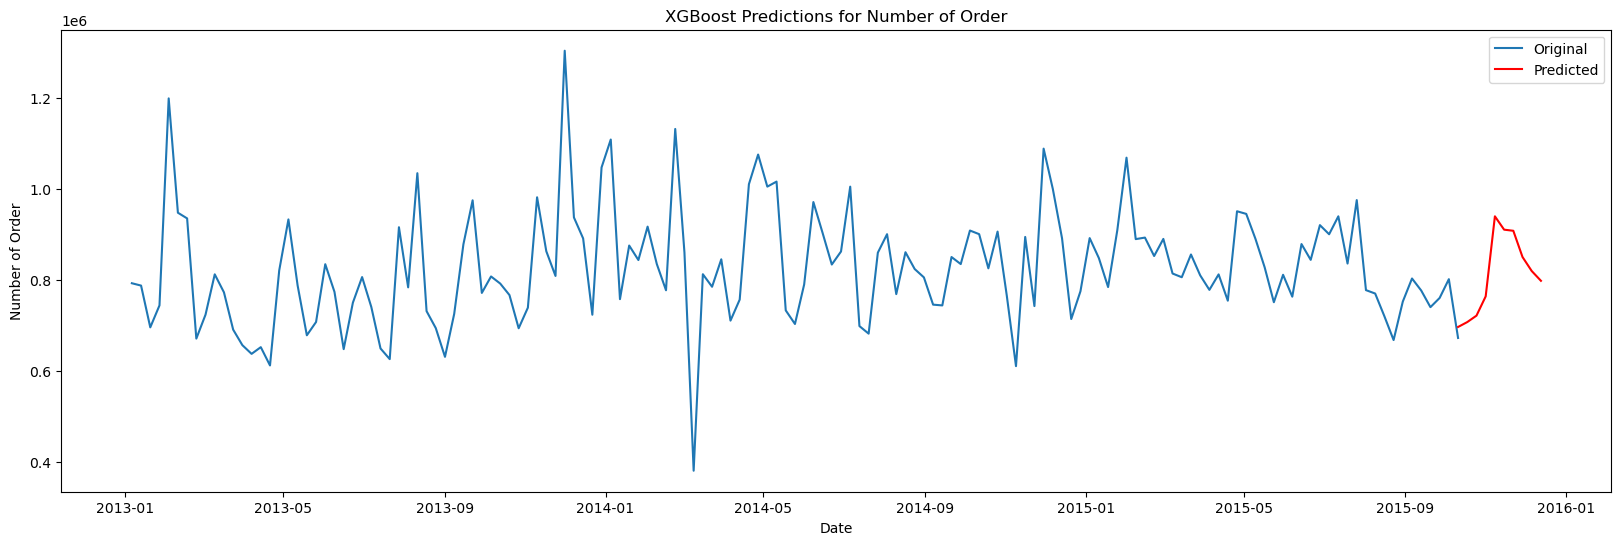

In [111]:
# Plot the original series
plt.figure(figsize=(20,6))
plt.plot(num_order, label='Original')

# Plot the predicted values
plt.plot(predicted_values, color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Number of Order')
plt.title('XGBoost Predictions for Number of Order')
plt.legend()
plt.show()